# Выделение групп пользователей на основе поведения в мобильном приложении

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Шаг 1. Загрузка и изучение данных](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
    * [Общие преобразования](#step_2_1)
    * [Добавление временных признаков](#step_2_2)
    * [Расчет пользовательской сессии](#step_2_3)
    * [Расчет периодичности событий](#step_2_4)
    * [Расчет времени активности](#step_2_5)
* [Шаг 3. Исследовательский анализ данных](#step_3)
    * [Расчет Retention Rate](#step_3_1)
    * [Время проведенное в приложении](#step_3_2)
    * [Частота действий](#step_3_3)
    * [Расчет конверсии в целевое действие](#step_3_4)
    * [Выводы по шагу 3](#step_3_5)
* [Шаг 4. Сегментация](#step_4)
    * [Создание профилей пользователей](#step_4_1)
    * [Кластеризация](#step_4_2)
* [Шаг 5. Основные вопросы исследования](#step_5)
    * [Определение группы, склонной чаще возвращаться в приложение](#step_5_1)
    * [Определение группы, склонной чаще совершать целевое действие](#step_5_2)
    * [Выводы по шагу 5](#step_5_3)
* [Шаг 6. Проверка гипотез](#step_6)
    * [Гипотеза 1](#step_6_1)
    * [Гипотеза 2](#step_6_2)
* [Выводы и рекомендации](#final)
    * [Выводы](#final_1)
    * [Рекомендации по развитию приложения](#final_2)

**Презентация** - https://drive.google.com/file/d/19XhAxx1YBcRpMKuCRNNjZqYI4MLf0Kap/view?usp=sharing

**Дашборд** - https://public.tableau.com/app/profile/dmitry.kostin/viz/Mobile_app_dashboard_16729994555230/Dashboard1?publish=yes

### Описание проекта

**Цель проекта:** на основе анализа удержания, проведенного времени в приложении, частоты действий и конверсии выделить группы пользователей на основе их поведения. Определить, какая группа склонна чаще возвращаться в приложение и какая группа склонна демонстрировать больше целевых действий. На основе полученых результатов, предложить рекомендации по развитию приложения и по воздействию на полученные группы.

В проекте необходимо выделить группы пользователей, которые различаются по метрикам:

1. Retention Rate;
2. время, проведённое в приложении; 
3. частота действий; 
4. конверсия в целевое действие — просмотр контактов.

### Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## Шаг 1. Загрузка и изучение данных <a class='anchor' id='step_1'></a>

Загрузим необходимые библиотеки.

In [11]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats as st
import math as mth
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

Загрузим необходимые для проекта функции.

In [12]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [13]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

In [14]:
# функция для построения парных bar chart
def pair_bar_chart(x, y_1, y_2, name_1, name_2, plot_title, xaxis_t, yaxis_t, legend_outside=False):
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=x,
        y=y_1,
        name=name_1,
        marker_color='rgb(55, 83, 109)',
        text=y_1,
        textposition='auto'
    ))
    fig.add_trace(go.Bar(
        x=x,
        y=y_2,
        name=name_2,
        marker_color='rgb(26, 118, 255)',
        text=y_2,
        textposition='auto'
    ))

    fig.update_layout(
        title=plot_title,
        xaxis_tickfont_size=14,
        xaxis=dict(title=xaxis_t),
        yaxis=dict(
            title=yaxis_t,
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        barmode='group',
        bargap=0, 
        bargroupgap=0.1 
    )
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

    if legend_outside == True:
        fig.update_layout(legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ))
    else:
        fig.update_layout(legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'))
    fig.show()

In [15]:
# функция для построения тепловой карты Retention Rate
def show_retention(data, sort=True):

    if sort == True:
        data = data.sort_values(by=[1, 2, 3], ascending=False)

    plt.figure(figsize=(28, 10))
    sns.heatmap(data.astype('float'), 
                annot=True, 
                annot_kws={"fontsize":14}, 
                fmt='.2%', 
                cmap='viridis')
    
    plt.title('Retention Rate когорт пользователей', fontsize=20, pad=20)
    plt.xlabel('Lifetime пользователя', fontsize=15)
    plt.ylabel('Дата формирования когорты', fontsize=15);

In [16]:
# функция для построения тепловой карты Conversion Rate
def show_conversion(data, sort=True):

    if sort == True:
        data = data.sort_values(by=[13, 12, 11], ascending=False)

    plt.figure(figsize=(28, 10))
    sns.heatmap(data.astype('float'), 
                annot=True, 
                annot_kws={"fontsize":14}, 
                fmt='.2%', 
                cmap='viridis')
    
    plt.title('Conversion Rate когорт пользователей', fontsize=20, pad=20)
    plt.xlabel('Lifetime пользователя', fontsize=15)
    plt.ylabel('Дата формирования когорты', fontsize=15);

Загрузим необходимые датасеты.

In [17]:
data = pd.read_csv('mobile_dataset.csv')

In [18]:
sources = pd.read_csv('mobile_sourсes.csv')

In [19]:
get_info(data)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [20]:
get_na(data)

,NaN
event.time,0.00%
event.name,0.00%
user.id,0.00%


В датасете не обнаружено дубликатов и пропусков, все столбцы имеют строковый формат данных.

In [21]:
get_info(sources)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [22]:
get_na(sources)

,NaN
userId,0.00%
source,0.00%


В датасете также не обнаружено дубликатов и пропусков, все столбцы имеют строковый формат данных.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

### Общие преобразования <a class='anchor' id='step_2_1'></a>

Скорректируем названия столбцов на более удобные.

In [23]:
data.columns = ['event_time', 'event_name', 'user_id']
sources.columns = ['user_id', 'source']

Среди событий можно встретить неявные дубликаты `contacts_show` и `show_contacts`, которые по смыслу описывают одно и то же событие - просмотр контактов.

In [24]:
print('Строки с contacts_show:', len(data[data['event_name'] == 'contacts_show']))
print('Строки с show_contacts:', len(data[data['event_name'] == 'show_contacts']))

Строки с contacts_show: 4450
Строки с show_contacts: 79


Приведем названия к единому виду `contacts_show`.

In [25]:
data.loc[data['event_name'] == 'show_contacts', 'event_name'] = 'contacts_show'

Добавим информацию об источниках в основной датафрейм.

In [26]:
data = data.merge(sources, on='user_id', how='left')

### Добавление временных признаков <a class='anchor' id='step_2_2'></a>

Приведем столбец `event_time` к временному формату `datetime`.

In [27]:
data['event_time'] = pd.to_datetime(data['event_time'])

Добавим в датасет следующие столбцы:
- `event_dt` - дата события;
- `event_hour` - час события;
- `event_weekday` - день недели события в цифровом формате;
- `event_week` - номер недели события. 

In [28]:
data['event_dt'] = data['event_time'].dt.date
data['event_dt'] = data['event_dt'].astype('str')
data['event_hour'] = data['event_time'].dt.hour
data['event_weekday'] = data['event_time'].dt.weekday + 1
data['event_week'] = data['event_time'].dt.isocalendar().week

In [29]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,1,41
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,1,41
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,1,41
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,0,1,41
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,0,1,41


### Расчет пользовательской сессии <a class='anchor' id='step_2_3'></a>

Отсортируем датасет по пользователям и времени событий.

In [30]:
data = data.sort_values(by=['user_id', 'event_time'])

Создадим столбец `previous_event`, в котором запишем время предыдущего события.

In [31]:
data['previous_event'] = data.groupby(['user_id'])['event_time'].shift(1)

Создадим столбец `timedelta`, в котором запишем разницу между временем текущего события и предыдущего. Переведем значения разниц в секунды.

In [32]:
data['timedelta'] = data['event_time'] - data['previous_event']
data['timedelta'] = data['timedelta'].astype('timedelta64[s]')

In [33]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0


Завершением сессии будем считать факт отсутствия активности пользователя в течении 30 минут - это общепринятая практика придерживаться такого интервала в случае отсутствия данных о логировании пользователей. За это время пользователь может успеть принять решение в зависимости от своих интересов и либо вернуться в приложение, либо отложить свой вопрос. В переменной `timeout` запишем значение таймаута, выраженного в секундах.

In [34]:
timeout = 30 * 60

Создадим столбец `is_new_session`, в котором будем помечать начало новой сессии флагом `True`. Также, с помощью кумулятивной суммы проставим идентификаторы сессии `session_id` для каждого пользователя.

In [35]:
data['is_new_session'] = (data['timedelta'].isna()) | (data['timedelta'] > timeout)
data['session_id'] = data.groupby('user_id')['is_new_session'].cumsum()

In [36]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1


Рассчитаем продолжительность каждой новой сессии пользователей и запишем их в датафрейм `session_duration`. Разрывы между сессиями учитывать не будем. Присоединим полученные данные к основному датафрейму `data`, записав продолжительность сессий в столбец `duration`.

In [37]:
session_duration = (data
                    .groupby(['user_id', 'session_id', 'is_new_session'], as_index=False)
                    .agg({'timedelta':'sum'})
                    .rename(columns={'timedelta':'duration'}))
session_duration = session_duration[session_duration['is_new_session'] == False][['user_id', 'session_id', 'duration']]

In [38]:
data = data.merge(session_duration, how='left', on=['user_id', 'session_id'])

In [39]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0


Создадим столбец `intervals`, в котором будем хранить очищенные от разрывов интервалы между событиями внутри каждой сессии.

In [40]:
data['intervals'] = data['timedelta'].apply(lambda x: 0 if x >= timeout else x)
data['intervals'] = data['intervals'].fillna(0)

In [41]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0,135.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0,130.0


### Расчет периодичности событий <a class='anchor' id='step_2_4'></a>

Рассчитаем количество событий за час, день и неделю для каждого пользователя и присоединим их к основному датафрейму.

In [42]:
events_per_hour = (data
                   .groupby(['user_id', 'event_week', 'event_dt', 'event_hour'], 
                            as_index=False)
                   .agg({'event_time':'count'})
                   .rename(columns={'event_time':'events'}))
data = data.merge(events_per_hour, how='left', on=['user_id', 'event_week', 'event_dt', 'event_hour']).rename(columns={'events':'events_per_hour'})

In [43]:
events_per_day = events_per_hour.groupby(['user_id', 'event_dt'], as_index=False).agg({'events':'sum'})
data = data.merge(events_per_day, how='left', on=['user_id', 'event_dt']).rename(columns={'events':'events_per_day'})

In [44]:
events_per_week = events_per_hour.groupby(['user_id', 'event_week'], as_index=False).agg({'events':'sum'})
data = data.merge(events_per_week, how='left', on=['user_id', 'event_week']).rename(columns={'events':'events_per_week'})

In [45]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals,events_per_hour,events_per_day,events_per_week
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0,9,9,13
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0,9,9,13
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0,9,9,13
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0,135.0,9,9,13
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0,130.0,9,9,13


Рассчитаем количество событий за сессию для каждого пользователя и присоединим их к основному датафрейму.

In [46]:
events_per_session = data.groupby(['user_id', 'session_id'], as_index=False).agg({'event_time':'count'}).rename(columns={'event_time':'events_per_session'})
data = data.merge(events_per_session, how='left', on=['user_id', 'session_id'])

In [47]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals,events_per_hour,events_per_day,events_per_week,events_per_session
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0,9,9,13,9
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0,9,9,13,9
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0,9,9,13,9
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0,135.0,9,9,13,9
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0,130.0,9,9,13,9


Рассчитаем суммарное количество событий для каждого пользователя и присоединим их к основному датафрейму.

In [48]:
total_events = data.groupby('user_id', as_index=False).agg({'event_time':'count'}).rename(columns={'event_time':'total_events'})
data = data.merge(total_events, how='left', on='user_id')

In [49]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals,events_per_hour,events_per_day,events_per_week,events_per_session,total_events
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0,9,9,13,9,35
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0,9,9,13,9,35
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0,9,9,13,9,35
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0,135.0,9,9,13,9,35
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0,130.0,9,9,13,9,35


### Расчет времени активности <a class='anchor' id='step_2_5'></a>

Рассчитаем временные метрики для каждого пользователя (в секундах) и добавим их в основном датафрейм:
- `time_spent_per_day` - проведенное время в приложении за день;
- `time_spent_per_week` - проведенное время в приложении за неделю;
- `time_spent_total` - суммарное проведенное время в приложении за весь период исследования.

In [50]:
time_spent_per_day = data.groupby(['user_id', 'event_dt'], as_index=False).agg({'intervals':'sum'}).rename(columns={'intervals':'time_spent_per_day'})
data = data.merge(time_spent_per_day, how='left', on=['user_id', 'event_dt'])

In [51]:
time_spent_per_week = data.groupby(['user_id', 'event_week'], as_index=False).agg({'intervals':'sum'}).rename(columns={'intervals':'time_spent_per_week'})
data = data.merge(time_spent_per_week, how='left', on=['user_id', 'event_week'])

In [52]:
time_spent_total = data.groupby('user_id', as_index=False).agg({'intervals':'sum'}).rename(columns={'intervals':'time_spent_total'})
data = data.merge(time_spent_total, how='left', on='user_id')

In [53]:
data.head()

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals,events_per_hour,events_per_day,events_per_week,events_per_session,total_events,time_spent_per_day,time_spent_per_week,time_spent_total
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0,9,9,13,9,35,592.0,1098.0,2746.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0,9,9,13,9,35,592.0,1098.0,2746.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0,9,9,13,9,35,592.0,1098.0,2746.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:41:05.722489,135.0,False,1,592.0,135.0,9,9,13,9,35,592.0,1098.0,2746.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:43:20.735461,130.0,False,1,592.0,130.0,9,9,13,9,35,592.0,1098.0,2746.0


[Назад к содержанию](#table_of_contents)

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

### Расчет Retention Rate <a class='anchor' id='step_3_1'></a>

Создадим функцию `retention_rate` для рассчета коэффициента удержания в разрезе каждодневных когорт. Функция будет рассчитывать количество уникальных посетителей каждый день с 7 октября по 3 ноября, привязывая их к соответствующей когорте и выделяя количество вернувшихся пользователей на следующий день.

Четное количество дней (28) позволяет поделить всех пользователей на нечетное количество когорт. Поэтому поделим пользователей на 15 когорт, а горизонтом анализа возьмем отрезок 14 дней (с 7 по 21 октября).

In [54]:
def retention_rate(data):
    dates = list(data['event_dt'].astype('str').sort_values().unique())
    retention_base = data.groupby('event_dt').agg({'user_id':'nunique'}).reset_index()
    retention = data.groupby('event_dt').agg({'user_id':'nunique'}).reset_index()

    for start in dates:
        for next in dates:
            start_day = pd.DataFrame(data[data['event_dt'] == start]['user_id'].unique())
            next_days = pd.DataFrame(data[data['event_dt'] == next]['user_id'].unique())
            unique_users = start_day.merge(next_days, how='inner')
            retention.loc[retention['event_dt'] == next, 'user_id'] = len(unique_users)
        retention_base = retention_base.merge(retention, on='event_dt', how='left')
        retention_base = retention_base.rename(columns={'user_id':start})

    retention_base = retention_base.drop('user_id_x', axis=1)
    retention = pd.DataFrame(np.tril(retention_base, k=1))
    retention['lifetime'] = pd.Series(range(28))
    for i in range(2, 29):
        retention[i] = retention[i].shift(-i+1)

    retention.columns = ['event_dt'] + list(range(28)) + ['lifetime']

    for i in range(28):
        column_name = str(i) + ' ' + 'day'
        retention[column_name] = retention[i] / retention.loc[0, i]

    retention_rate = retention.loc[:, '0 day':]
    retention_rate = retention_rate.loc[:13, :'14 day'].T
    retention_rate.insert(0, 'dates', dates[:15])
    retention_rate = retention_rate.set_index('dates').drop(0, axis=1)

    return retention_rate

С помощью функции расчитаем датафрейм с коэффициентами удержания. Индексами являются даты начала когорт, а названиями столбцов являются дни соответствующего лайфтайма.

In [55]:
result_retention = retention_rate(data)
result_retention.style.format('{:.2%}')

,1,2,3,4,5,6,7,8,9,10,11,12,13
dates,,,,,,,,,,,,,
2019-10-07,18.14%,10.29%,10.78%,6.86%,5.88%,3.92%,7.84%,6.37%,4.90%,6.86%,3.92%,1.96%,3.92%
2019-10-08,19.61%,14.22%,11.27%,4.90%,3.43%,6.86%,5.88%,6.37%,7.84%,5.88%,4.41%,1.96%,6.37%
2019-10-09,14.54%,11.89%,7.05%,7.05%,9.69%,8.81%,7.93%,9.25%,7.49%,3.52%,3.08%,6.17%,5.73%
2019-10-10,18.88%,10.73%,10.73%,10.73%,12.45%,8.58%,9.44%,7.73%,5.58%,5.15%,7.30%,5.15%,6.87%
2019-10-11,11.65%,11.17%,16.99%,13.11%,9.71%,9.71%,11.17%,4.85%,3.88%,7.77%,7.28%,6.80%,5.83%
2019-10-12,25.28%,15.73%,15.73%,10.11%,12.92%,12.36%,10.67%,9.55%,8.43%,7.87%,7.30%,6.74%,8.99%
2019-10-13,21.68%,16.81%,11.95%,10.62%,9.73%,7.96%,11.50%,7.52%,8.85%,6.64%,6.19%,5.75%,6.64%
2019-10-14,22.82%,16.44%,13.76%,14.77%,7.72%,9.06%,9.73%,8.39%,9.06%,7.38%,5.03%,6.04%,5.70%
2019-10-15,22.77%,17.82%,13.86%,10.23%,9.90%,10.56%,10.23%,11.88%,6.93%,7.59%,5.61%,6.27%,6.93%


Построим тепловую карту на основе полученных данных `result_retention`. Отсортируем тепловую карту по первым пяти дням лайфтайма по убыванию.

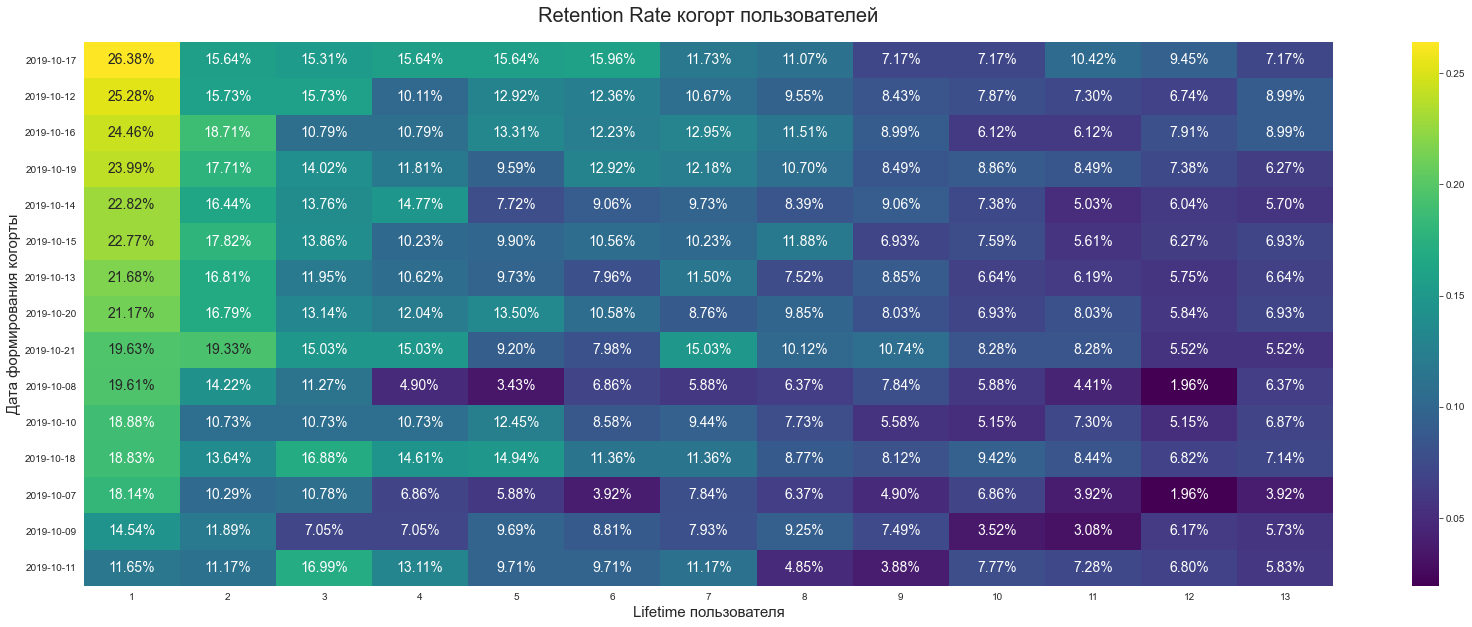

In [56]:
show_retention(result_retention)

Наилучшее удержание показывают когорты, начавшие активность 12, 16, 17 и 19 октября (всего 4 когорты). 

В среднем их удержание составляло: 
- 24-26% на 1-й день лайфтайма; 
- 11-13% на 7-й день лайфтайма; 
- 6-9% на 13-й день лайфтайма.

Худшее удержание показывают когорты, начавшие активность с 7 по 11 октября (всего 5 когорт).

В среднем их удержание составляло:
- 11-20% на 1-й день лайфтайма;
- 6-11% на 7-й день лайфтайма;
- 4-7% на 13-й день лайфтайма.

### Время проведенное в приложении <a class='anchor' id='step_3_2'></a>

Создадим датафрейм `users`, в котором рассчитаем время проведенное в приложении - суммарно в секундах, минутах и часах. В дальнейшем будем присоединять к датафрейму всю сводную статистику по каждому пользователю.

In [57]:
users = data[['user_id', 'time_spent_total']].drop_duplicates()
users['min'] = users['time_spent_total'] / 60
users['hours'] = users['time_spent_total'] / (60 * 60)
users = users.rename(columns={'min':'minutes_spent', 'hours':'hours_spent'})
users.head()

,user_id,time_spent_total,minutes_spent,hours_spent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2746.0,45.766667,0.762778
35,00157779-810c-4498-9e05-a1e9e3cedf93,11742.0,195.700000,3.261667
106,00463033-5717-4bf1-91b4-09183923b9df,1477.0,24.616667,0.410278
116,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6631.0,110.516667,1.841944
148,00551e79-152e-4441-9cf7-565d7eb04090,557.0,9.283333,0.154722


Узнаем, сколько пользователей провело в приложении не более 1 часа за исследуемый период (28 дней) и сколько пользователей не заходило в приложение в принципе.

In [58]:
one_hour_users = users[(users['hours_spent'] < 1) & (users['hours_spent'] != 0)]
zero_hour_users = users[users['hours_spent'] == 0]
print('Число пользователей, которые провели не более 1 часа:', len(one_hour_users))
print('Число пользователей, которые не заходили в приложение:', len(users[users['hours_spent'] == 0]))

Число пользователей, которые провели не более 1 часа: 3700
Число пользователей, которые не заходили в приложение: 90


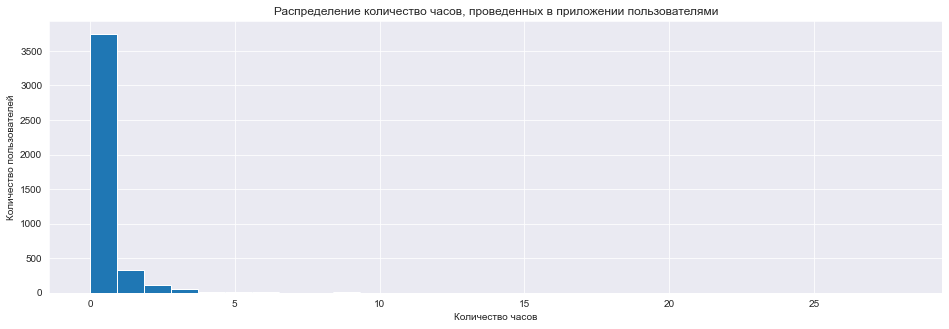

In [59]:
users['hours_spent'].hist(bins=30, figsize=(16,5))
plt.title('Распределение количество часов, проведенных в приложении пользователями')
plt.xlabel('Количество часов')
plt.ylabel('Количество пользователей');

Как видим, подавляющее число пользователей (более 86%) провело в приложении не более 1 часа за 28 дней. 2% пользователей не пользовались приложением в исследуемом периоде.

Рассчитаем суммарное количество дней активности у каждого пользователя.

In [60]:
active_days = (data
               .groupby('user_id', as_index=False)
               .agg({'event_dt':'nunique'})
               .rename(columns={'event_dt':'active_days'}))
users = users.merge(active_days, on='user_id', how='left')

In [61]:
users['active_days'].value_counts(normalize=True).head()

1    0.641975
2    0.183089
3    0.080596
4    0.037503
5    0.020033
Name: active_days, dtype: float64

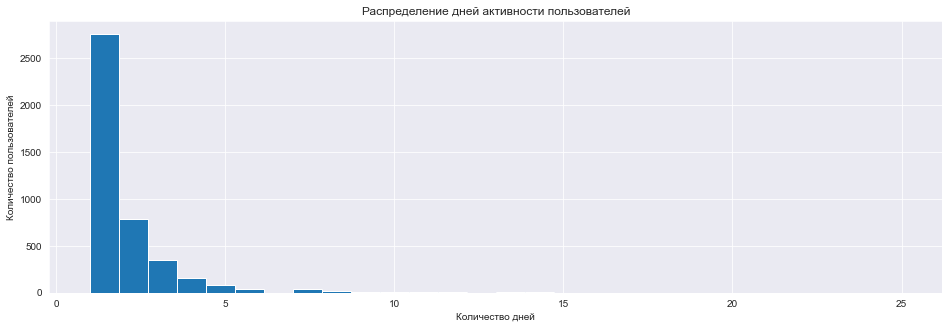

In [62]:
users['active_days'].hist(bins=28, figsize=(16,5))
plt.title('Распределение дней активности пользователей')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей');

Можно сделать следующие выводы об активности пользователей:
- 64% пользователей (2 756 чел.) имели лишь один день активности за 28 дней;
- 18% пользователей (786 чел.) имели два дня активности;
- 8% пользователей (346 чел.) имели три дня активности;
- 10% пользователей (405 чел.) были активны 4 дня и более. 

Рассчитаем суммарное количество сессий у каждого пользователя.

In [63]:
total_sessions = (data
                  .groupby('user_id', as_index=False)
                  .agg({'is_new_session':'sum'})
                  .rename(columns={'is_new_session':'total_sessions'}))
users = users.merge(total_sessions, on='user_id', how='left')

In [64]:
display(users['total_sessions'].value_counts(normalize=True).head())
display(users['total_sessions'].value_counts().head())

1    0.535756
2    0.204519
3    0.107617
4    0.055672
5    0.025390
Name: total_sessions, dtype: float64

1    2300
2     878
3     462
4     239
5     109
Name: total_sessions, dtype: int64

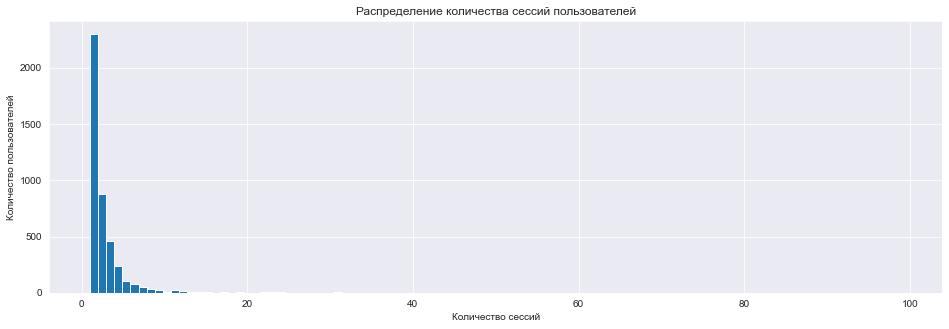

In [65]:
total_sessions.hist(bins=100, figsize=(16,5))
plt.title('Распределение количества сессий пользователей')
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей');

Можно сделать следующие выводы о количестве сессий пользователей:
- 53% пользователей (2 300 чел.) имели лишь одну сессию за 28 дней;
- 20% пользователей (878 чел.) имели две сессии;
- 10% пользователей (462 чел.) имели три сессии;
- 17% пользователей (653 чел.) провели 4 сессии и более.

### Частота действий <a class='anchor' id='step_3_3'></a>

Узнаем в какие даты пользователи были наиболее активны и совершили больше всего целевых действий.

In [66]:
contacts = (data[data['event_name'] == 'contacts_show']
            .groupby('event_dt')
            .agg({'event_time':'count'})
            .reset_index()
            .rename(columns={'event_time':'contacts_show'}))
total = (data
         .groupby('event_dt')
         .agg({'event_time':'count'})
         .reset_index()
         .rename(columns={'event_time':'events'}))
total = total.merge(contacts, on='event_dt', how='left')

In [67]:
pair_bar_chart(x=total['event_dt'],
               y_1=total['events'],
               y_2=total['contacts_show'],
               name_1='Событий всего',
               name_2='Целевое действие - просмотр контактов',
               plot_title='Распределение активности и целевых действий пользователей по датам',
               xaxis_t='Даты',
               yaxis_t='Количество событий')

На протяжении всего времени в среднем пользовательская активность держится на уровне 2 000 - 3 000 событий в день. Самым активным днем было 23 октября - в этот день произошло 3 361 событий, из которых 239 целевых действий. 

Наименее активным днем было 12 октября - в этот день произошло лишь 1 843 события.

В среднем уровень целевых действий держится на уровне 50-270 в день, достигая не более 10% от всех действий за день.

Больше всего целевых действий было совершено 17 октября - 265 событий (10% от событий этого дня). Наименьшее количество было совершено 12 октября - лишь 54 (3% от всех событий).

Рассмотрим активность пользователей и количество целевых действий в разбивке по часам суток.

In [68]:
total_h = data.groupby('event_hour').agg({'event_time':'count'}).reset_index().rename(columns={'event_time':'events'})
contacts_h = (data[data['event_name'] == 'contacts_show']
            .groupby('event_hour')
            .agg({'event_time':'count'})
            .reset_index()
            .rename(columns={'event_time':'contacts_show'}))
total_h = total_h.merge(contacts_h, on='event_hour', how='left')

In [69]:
pair_bar_chart(x=total_h['event_hour'],
               y_1=total_h['events'],
               y_2=total_h['contacts_show'],
               name_1='Событий всего',
               name_2='Целевое действие - просмотр контактов',
               plot_title='Распределение активности и целевых действий пользователей по часам суток',
               xaxis_t='Часы суток',
               yaxis_t='Количество событий')

Пользовательская активность падает в ночные часы, и, начиная с 6 утра постепенно начинает возрастать. Пиковые значения активности приходятся на 15 часов дня, достигая уровня более 5 600 событий. Далее происходит спад, после которого в период с 18 до 21 часа наблюдается новый рост до уровня максимумов за день.

Похожим образом распределяются и целевые действия. Их пиковые значения приходятся в отрезок с 11 часов утра до 16 часов дня - в среднем на уровне 400 действий в час (около 7-9% от всех событий).

Рассмотрим активность пользователей в разбивке по дням недели.

In [70]:
total_w = (data
           .groupby('event_weekday')
           .agg({'event_time':'count'})
           .reset_index()
           .rename(columns={'event_time':'events'}))
contacts_w = (data[data['event_name'] == 'contacts_show']
            .groupby('event_weekday')
            .agg({'event_time':'count'})
            .reset_index()
            .rename(columns={'event_time':'contacts_show'}))
total_w = total_w.merge(contacts_w, on='event_weekday', how='left')

In [71]:
pair_bar_chart(x=total_w['event_weekday'],
               y_1=total_w['events'],
               y_2=total_w['contacts_show'],
               name_1='Событий всего',
               name_2='Целевое действие - просмотр контактов',
               plot_title='Распределение активности и целевых действий пользователей по дням недели',
               xaxis_t='Дни недели',
               yaxis_t='Количество событий',
               legend_outside=True)

Наибольшая активность пользователей приходится на понедельник, после чего постепенно снижается в течение всей недели. Количество целевых действий напротив возрастает, начиная с понедельника и достигает максимума в четверг. Наиболее низкие значения целевых действий пользователи демонстрируют в выходные дни.

Рассмотрим суммарное количество событий пользователей.

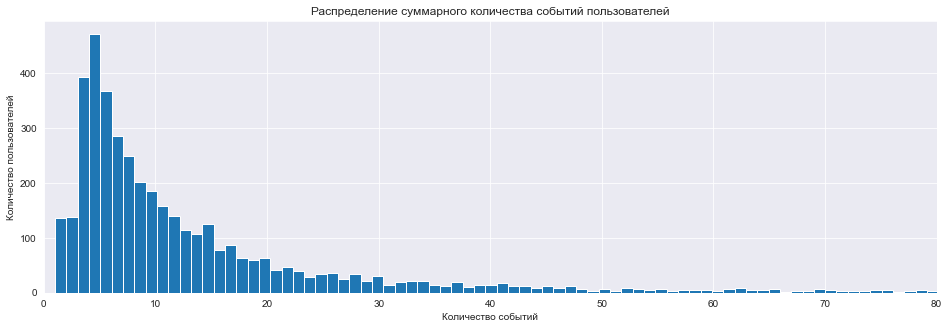

In [73]:
data[['user_id', 'total_events']].drop_duplicates().reset_index(drop=True).hist(bins=470, figsize=(16,5))
plt.title('Распределение суммарного количества событий пользователей')
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 80);

In [74]:
data[['user_id', 'total_events']].drop_duplicates().reset_index(drop=True)['total_events'].describe()

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: total_events, dtype: float64

В среднем пользователи имеют 17 событий за исследуемый период. Медианное значение - 9 событий. Количество событий 90% пользователей составляет не более 36 событий. Лишь 5% пользователей совершили более 59 действий.

Рассмотрим средние интервалы в секундах между событиями пользователей во время активной сессии.

In [75]:
users = (users
         .merge(data.groupby(['user_id'], as_index=False)
         .agg({'intervals':'mean'}), on='user_id', how='left')
         .rename(columns={'intervals':'avg_intervals'}))

In [76]:
users['avg_intervals'].describe()

count    4293.000000
mean      105.803196
std        84.951472
min         0.000000
25%        48.500000
50%        85.636364
75%       138.400000
max       697.250000
Name: avg_intervals, dtype: float64

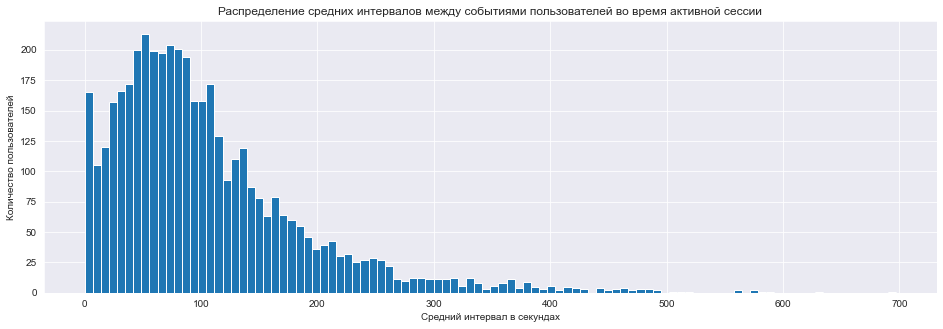

In [77]:
users['avg_intervals'].hist(bins=100, figsize=(16,5))
plt.title('Распределение средних интервалов между событиями пользователей во время активной сессии')
plt.ylabel('Количество пользователей')
plt.xlabel('Средний интервал в секундах');

В среднем интервал пользователя между событиями внутри сессии составляет 1 минута 45 секунд (105 секунд). Медианное значение интервалов составляет около полторы минуты (85 секунд). Размер интервалов между действиями 75% пользователей не превышает 2-х минут (138 секунд). 10% пользователей имеют интервалы более 3.5 минут (213 секунд) и лишь 1% - более 7 минут (416 секунд). 

Виден резкий всплеск около 0 - это пользователи, которые не совершали действий и сессии, а соответственно имеют нулевое значени средних интервалов. 

Расмотрим средний разрыв между сессиями. В датафрейме `breakups` запишем столбцы:
- `avg_hours_breakup` - среднее число часов между сессиями;
- `avg_days_breakup` - среднее число дней между сессиями.

In [78]:
breakups = data[data['timedelta'] > timeout].groupby('user_id', as_index=False).agg({'timedelta':'mean'})
breakups['hours'] = breakups['timedelta'] / (60 * 60)
breakups['days'] = breakups['timedelta'] / (24 * 60 * 60)
breakups = breakups.rename(columns={'hours':'avg_hours_breakup', 'days':'avg_days_breakup'}).drop('timedelta', axis=1)
users = users.merge(breakups, on='user_id', how='left')
breakups.head()

,user_id,avg_hours_breakup,avg_days_breakup
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,119.028148,4.959506
1,00157779-810c-4498-9e05-a1e9e3cedf93,70.471056,2.936294
2,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,61.924611,2.580192
3,00551e79-152e-4441-9cf7-565d7eb04090,40.693194,1.695550
4,00554293-7e00-4122-b898-4e892c4a7c53,1.348333,0.056181


In [79]:
breakups['avg_days_breakup'].describe()

count    1993.000000
mean        2.515394
std         3.566619
min         0.020880
25%         0.348612
50%         1.127712
75%         3.163976
max        26.576319
Name: avg_days_breakup, dtype: float64

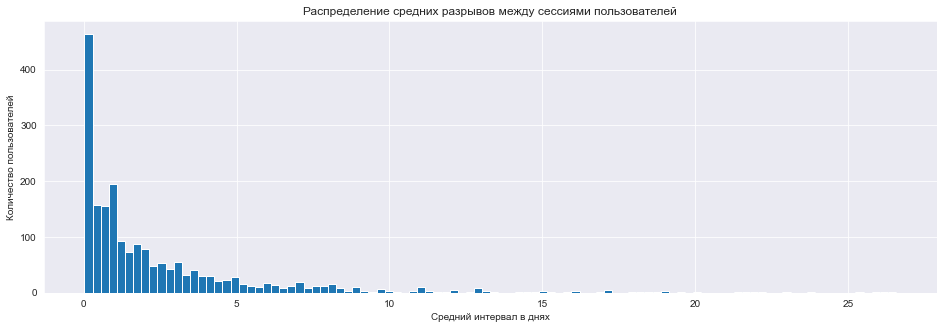

In [80]:
breakups['avg_days_breakup'].hist(bins=100, figsize=(16,5))
plt.title('Распределение средних разрывов между сессиями пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Средний интервал в днях');

В расчетах учтены только те пользователи, которые совершили как минимум 2 сессии.
В среднем перерыв между сессиями пользователей составляет 2 с половиной дня. Медианное значение - 1 день. Из всех активных пользователей (всего 1 993 чел.): 
- 50% пользователей заходят в приложение 1 раз в 2 дня; 
- 75% пользователей заходят в приложение каждые 3 дня; 
- 9% пользователей заходят 1 раз в неделю; 
- 4% заходят раз в 10 дней; 
- лишь 2% заходят раз в 2 недели.

Расчитаем время до совершения целевого действия (просмотр контактов) во время сессии каждого пользователя. Сперва найдем все сессии, в которых произошло целевое действие. В столбце `first_session_event` запишем временную метку первого события сессии, а в столбце `contacts_show_ts` запишем временную метку целевого действия, после чего найдем их разницу внутри каждой сессии. Полученный столбец `target_time` выразим в минутах.

In [81]:
target_sessions = data[data['event_name'] == 'contacts_show'][['user_id', 'session_id']].drop_duplicates()
target_sessions = target_sessions.merge(data, how='inner', on=['user_id', 'session_id'])
first_session_event = (target_sessions
                       .groupby(['user_id', 'session_id'])
                       .agg({'event_time':'first'})
                       .rename(columns={'event_time':'first_session_event'}))
contacts_show_events = (target_sessions[target_sessions['event_name'] == 'contacts_show']
                        .groupby(['user_id', 'session_id'])
                        .agg({'event_time':'first'})
                        .rename(columns={'event_time':'contacts_show_ts'}))
target = first_session_event.merge(contacts_show_events, on=['user_id', 'session_id'], how='left')
target['target_time'] = target['contacts_show_ts'] - target['first_session_event']
target['target_time'] = target['target_time'].astype('timedelta64[m]')

In [82]:
target.head(6)

first_session_event  \
user_id                              session_id                              
00157779-810c-4498-9e05-a1e9e3cedf93 2          2019-10-20 18:49:24.115634   
                                     4          2019-10-29 21:18:24.850073   
                                     5          2019-10-30 07:50:45.948358   
                                     6          2019-11-03 17:12:09.708771   
00551e79-152e-4441-9cf7-565d7eb04090 1          2019-10-25 16:44:41.263364   
                                     2          2019-10-28 13:08:15.809056   

                                                          contacts_show_ts  \
user_id                              session_id                              
00157779-810c-4498-9e05-a1e9e3cedf93 2          2019-10-20 19:17:18.659799   
                                     4          2019-10-29 21:26:40.258472   
                                     5          2019-10-30 08:01:05.420773   
                                     6          2019-11-03 17:12:09.708771   
00551e79-152e-4441-9cf7-565d7eb04090 1          2019-10-25 16:44:41.263364   
                                     2          2019-10-28 13:10:40.331441   

                                                 target_time  
user_id                              session_id               
00157779-810c-4498-9e05-a1e9e3cedf93 2                  27.0  
                                     4                   8.0  
                                     5                  10.0  
                                     6                   0.0  
00551e79-152e-4441-9cf7-565d7eb04090 1                   0.0  
                                     2                   2.0

Теперь рассчитаем среднее количество минут до совершения целевого действия и присоединим их к сводному датафрейму `users`.

In [83]:
target_time = (target
               .reset_index()
               .groupby('user_id', as_index=False)
               .agg({'target_time':'mean'})
               .rename(columns={'target_time':'avg_target_time'}))
users = users.merge(target_time, on='user_id', how='left')
target_time.head()

,user_id,avg_target_time
0,00157779-810c-4498-9e05-a1e9e3cedf93,11.25
1,00551e79-152e-4441-9cf7-565d7eb04090,1.00
2,005fbea5-2678-406f-88a6-fbe9787e2268,0.00
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,0.00
4,007d031d-5018-4e02-b7ee-72a30609173f,5.00


Рассчитаем описательные параметры сессий для каждого пользователя:
- `min_sess_dur` - минимальная продолжительность сессии пользователя; 
- `max_sess_dur` - максимальная продолжительность сессии пользователя;
- `avg_sess_dur` - средняя длительность сессии.

In [84]:
sessions_data = data.groupby('user_id', as_index=False).agg({'duration':['min', 'max', 'mean']})
sessions_data.columns = ['user_id', 'min_sess_dur', 'max_sess_dur', 'avg_sess_dur']
users = users.merge(sessions_data, on='user_id', how='left')
sessions_data.head()

,user_id,min_sess_dur,max_sess_dur,avg_sess_dur
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,506.0,893.0,739.828571
1,00157779-810c-4498-9e05-a1e9e3cedf93,389.0,4565.0,2739.842857
2,00463033-5717-4bf1-91b4-09183923b9df,1477.0,1477.0,1477.000000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,16.0,2356.0,1394.062500
4,00551e79-152e-4441-9cf7-565d7eb04090,3.0,554.0,396.571429


In [85]:
sessions_data['avg_sess_dur'].describe()

count     4210.000000
mean      1071.649510
std       1181.392238
min          0.000000
25%        313.000000
50%        708.125000
75%       1424.142857
max      18864.462366
Name: avg_sess_dur, dtype: float64

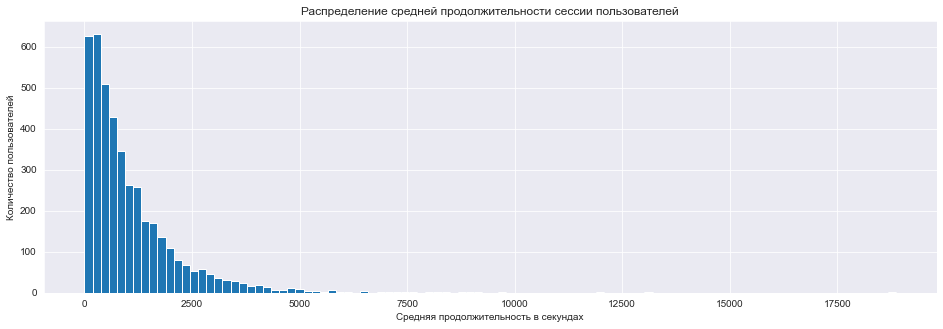

In [86]:
sessions_data['avg_sess_dur'].hist(bins=100, figsize=(16,5))
plt.title('Распределение средней продолжительности сессии пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Средняя продолжительность в секундах');

Средний размер сессии - 18 минут (1 071 секунд). Медианное значние - 12 минут (708 секунд). Максимум составил более 5 часов.
Длительность сессии 89% пользователей не превышает 40 минут (2 500 секунд). Длительность сессии 10% пользователей варьируется в интервале от 40 минут до 1 часа 20 минут. Лишь 1% пользователей совершает сессии дольше, чем полтора часа.

### Расчет конверсии в целевое действие <a class='anchor' id='step_3_4'></a>

Создадим функцию `conversion_rate` для рассчета коэффициента конверсии в разрезе каждодневных когорт. Функция будет рассчитывать количество уникальных посетителей каждый день с 7 октября по 3 ноября, привязывая их к соответствующей когорте и вычисляя кумулятивную сумму пользователей, совершивших просмотр контактов на каждый следующий день.

Четное количество дней (28) позволяет поделить всех пользователей на нечетное количество когорт. Поэтому поделим пользователей на 15 когорт, а горизонтом анализа возьмем отрезок 14 дней (с 7 по 21 октября).

In [87]:
def conversion_rate(data):
    
    dates = list(data['event_dt'].astype('str').sort_values().unique())
    conversion_base = data.groupby('event_dt').agg({'user_id':'nunique'}).reset_index()
    conversion = data.groupby('event_dt').agg({'user_id':'nunique'}).reset_index()

    for start in dates:
        start_day = pd.DataFrame(data[data['event_dt'] == start]['user_id'].unique())
        for next in dates:
            next_days = pd.DataFrame(data[(data['event_dt'] == next) & (data['event_name'] == 'contacts_show')]['user_id'].unique())
            unique_users = start_day.merge(next_days, how='inner')
            conversion.loc[conversion['event_dt'] == next, 'user_id'] = len(unique_users)
            user_exclusion = pd.merge(start_day, next_days, how='outer', indicator=True)
            start_day = pd.DataFrame(user_exclusion.loc[user_exclusion._merge == 'left_only', 0])

        conversion_base = conversion_base.merge(conversion, on='event_dt', how='left')
        conversion_base = conversion_base.rename(columns={'user_id':start})
        
    conversion_base = conversion_base.drop('user_id_x', axis=1)
    conversion = pd.DataFrame(np.tril(conversion_base, k=1))
    conversion['lifetime'] = pd.Series(range(28))

    for i in range(2, 29):
        conversion[i] = conversion[i].shift(-i+1)

    conversion.columns = ['event_dt'] + list(range(28)) + ['lifetime']

    for i in range(28):
        column_name = str(i) + ' ' + 'day'
        conversion[column_name] = conversion[i].cumsum()

    conversion_rate = conversion.loc[:, '0 day':]
    conversion_rate = conversion_rate.loc[:13, :'14 day'].T.reset_index().rename(columns={'index':'cohort'})
    cohorts = data.groupby('event_dt').agg({'user_id':'nunique'}).reset_index()['user_id'][:15]
    conversion_rate.insert(1, 'cohort_size', cohorts)
    conversion_rate = conversion_rate.loc[:, 0:].div(conversion_rate['cohort_size'], axis=0)
    conversion_rate.insert(0, 'dates', dates[:15])
    conversion_rate = conversion_rate.set_index('dates').drop(0, axis=1)

    return conversion_rate

С помощью функции расчитаем датафрейм с коэффициентами конверсии. Индексами являются даты начала когорт, а названиями столбцов являются дни соответствующего лайфтайма.

In [88]:
result_conversion = conversion_rate(data)
result_conversion.style.format('{:.2%}')

,1,2,3,4,5,6,7,8,9,10,11,12,13
dates,,,,,,,,,,,,,
2019-10-07,18.63%,18.63%,19.12%,19.12%,19.61%,20.10%,20.59%,21.08%,21.57%,22.55%,22.55%,22.55%,23.04%
2019-10-08,16.67%,17.65%,17.65%,18.14%,18.14%,18.63%,18.63%,18.63%,20.59%,21.08%,21.57%,21.57%,21.57%
2019-10-09,18.06%,18.94%,19.38%,19.82%,20.26%,20.70%,20.70%,22.03%,22.91%,23.35%,23.35%,23.79%,23.79%
2019-10-10,15.88%,16.31%,17.17%,17.60%,18.03%,18.03%,18.45%,18.45%,18.88%,19.31%,19.31%,19.74%,20.17%
2019-10-11,12.14%,12.14%,12.14%,12.14%,13.11%,13.59%,13.59%,14.56%,15.05%,15.05%,16.02%,16.50%,16.50%
2019-10-12,12.92%,13.48%,15.17%,16.29%,16.85%,17.42%,17.98%,17.98%,17.98%,18.54%,18.54%,19.10%,19.66%
2019-10-13,14.60%,16.81%,16.81%,17.70%,17.70%,17.70%,18.14%,18.14%,18.14%,18.58%,18.58%,18.58%,18.58%
2019-10-14,13.42%,14.09%,14.09%,15.10%,15.10%,15.44%,15.44%,15.77%,16.11%,16.11%,16.11%,16.11%,16.11%
2019-10-15,14.85%,15.51%,15.51%,15.51%,15.51%,15.51%,15.51%,15.84%,15.84%,15.84%,15.84%,16.17%,16.17%


Построим тепловую карту на основе полученных данных `result_conversion`. Отсортируем тепловую карту по последним трем дням лайфтайма по убыванию.

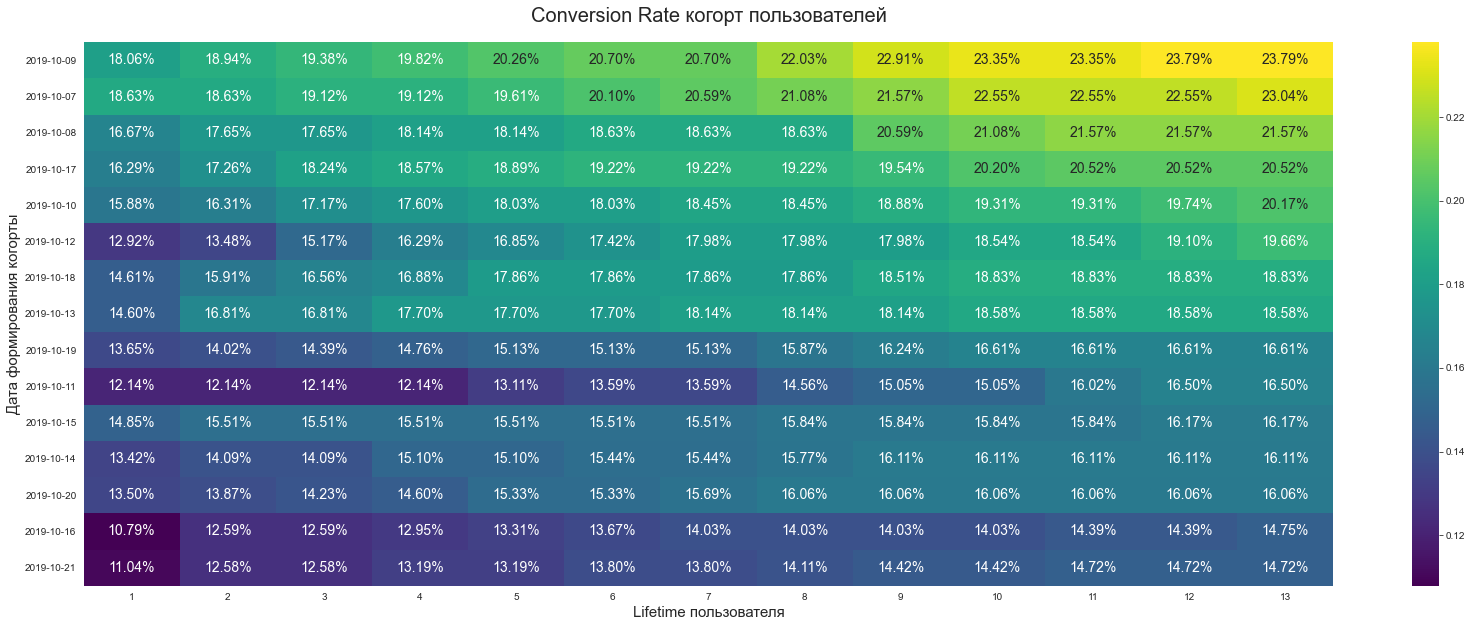

In [89]:
show_conversion(result_conversion)

В плане конверсии пользователи разбились на две части. 

Наилучшую конверсию показывают когорты от 7-10, 12, 13, 17 и 18 октября (всего 8 когорт).

В среднем их конверсия составляла:
- 19-24% на 13-й день лайфтайма;
- 18-21% на 7-й день лайфтайма;
- 13-19% на 1-й день лайфтайма.

Наименьшую конверсию демонстрируют когорты от 11, 14-16, 19-21 октября (всего 7 когорт).

В среднем их конверсия составляла:
- 15-17% на 13-й день лайфтайма;
- 14-16% на 7-й день лайфтайма;
- 11-15% на 1-й день лайфтайма.


Дополнительно, расчитаем долю просмотра контактов во всех действиях каждого пользователя и добавим данные в сводный датафрейм `users`.

In [90]:
event_count = data.groupby('user_id').agg({'event_name':'count'}).reset_index()
contacts_show_count = (pd.pivot_table(data, 
              index='user_id', 
              columns='event_name', 
              values='event_time', 
              aggfunc='count')[['contacts_show']].reset_index())
contacts_show_share = event_count.merge(contacts_show_count, on='user_id', how='left')
contacts_show_share['contacts_show_share'] = contacts_show_share['contacts_show'] / contacts_show_share['event_name']
users = users.merge(contacts_show_share[['user_id', 'contacts_show_share']], on='user_id', how='left')
contacts_show_share.head()

,user_id,event_name,contacts_show,contacts_show_share
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,NaN,NaN
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,11.0,0.15493
2,00463033-5717-4bf1-91b4-09183923b9df,10,NaN,NaN
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,NaN,NaN
4,00551e79-152e-4441-9cf7-565d7eb04090,8,3.0,0.37500


In [91]:
print('Кол-во пользователей, совершившие целевое действие:', contacts_show_share['contacts_show'].notna().sum())
print('Кол-во пользователей, не совершавших целевое действие:', contacts_show_share['contacts_show'].isna().sum())
print('Доля просмотра контактов от всех событий:', ((contacts_show_share['contacts_show_share']
                                                     .notna().sum()) / len(users)).round(4))

Кол-во пользователей, совершившие целевое действие: 981
Кол-во пользователей, не совершавших целевое действие: 3312
Доля просмотра контактов от всех событий: 0.2285


Среди пользователей, которые совершали целевое действие, в среднем 23% действий составляет просмотр контактов.

### Выводы по шагу 3 <a class='anchor' id='step_3_5'></a>

В ходе исследовательского анализа данных были проанализированы Retention Rate, время, проведенное в приложении, частота действий пользователей и конверсия в целевое действие.

По итогам анализа **Retention Rate** были получены следующие выводы:

1. Наилучшее удержание показывают когорты, начавшие активность 12, 16, 17 и 19 октября (всего 4 когорты). 

2. В среднем их удержание составляло 24-26% на 1-й день лайфтайма, 11-13% на 7-й день лайфтайма, 6-9% на 13-й день лайфтайма.

3. Худшее удержание показывают когорты, начавшие активность с 7 по 11 октября (всего 5 когорт).

4. В среднем их удержание составляло 11-20% на 1-й день лайфтайма, 6-11% на 7-й день лайфтайма, 4-7% на 13-й день лайфтайма.

По итогам анализа **времени, проведенного в приложении**, были получены следующие выводы:

1. Подавляющее число пользователей (более 86%) провело в приложении не более 1 часа за 28 дней. 2% пользователей не пользовались приложением в исследуемом периоде.

2. 64% пользователей (2 756 чел.) имели лишь один день активности за 28 дней; 18% пользователей (786 чел.) имели два дня активности; 8% пользователей (346 чел.) имели три дня активности; 10% пользователей (405 чел.) были активны 4 дня и более.

3. 53% пользователей (2 300 чел.) имели лишь одну сессию за 28 дней; 20% пользователей (878 чел.) имели две сессии; 10% пользователей (462 чел.) имели три сессии; 17% пользователей (653 чел.) провели 4 сессии и более.

По итогам **анализа частоты действий** были получены следующие выводы:

1. На протяжении всего времени в среднем пользовательская активность держится на уровне 2 000 - 3 000 событий в день. Самым активным днем было 23 октября - в этот день произошло 3 361 событий, из которых 239 целевых действий.

2. Наименее активным днем было 12 октября - в этот день произошло лишь 1 843 события.

3. В среднем уровень целевых действий держится на уровне 50-270 в день, достигая не более 10% от всех действий за день.

4. Больше всего целевых действий было совершено 17 октября - 265 событий (10% от событий этого дня). Наименьшее количество было совершено 12 октября - лишь 54 (3% от всех событий).

5. Пользовательская активность падает в ночные часы, и, начиная с 6 утра постепенно начинает возрастать. Пиковые значения активности приходятся на 15 часов дня, достигая уровня более 5 600 событий. Далее происходит спад, после которого в период с 18 до 21 часа наблюдается новый рост до уровня максимумов за день.

6. Похожим образом распределяются и целевые действия. Их пиковые значения приходятся в отрезок с 11 часов утра до 16 часов дня - в среднем на уровне 400 действий в час (около 7-9% от всех событий).

7. Наибольшая активность пользователей приходится на понедельник, после чего постепенно снижается в течение всей недели. Количество целевых действий напротив возрастает, начиная с понедельника и достигает максимума в четверг. Наиболее низкие значения целевых действий пользователи демонстрируют в выходные дни.

8. В среднем пользователи имеют 17 событий за исследуемый период. Медианное значение - 9 событий. Количество событий 90% пользователей составляет не более 36 событий. Лишь 5% пользователей совершили более 59 действий.

9. В среднем интервал пользователя между событиями внутри сессии составляет 1 минута 45 секунд (105 секунд). Медианное значение интервалов составляет около полторы минуты (85 секунд). Размер интервалов между действиями 75% пользователей не превышает 2-х минут (138 секунд). 10% пользователей имеют интервалы более 3.5 минут (213 секунд) и лишь 1% - более 7 минут (416 секунд).

10. В расчетах учтены только те пользователи, которые совершили как минимум 2 сессии. В среднем перерыв между сессиями пользователей составляет 2 с половиной дня. Медианное значение - 1 день. 

11. Из всех активных пользователей (всего 1 993 чел.): 50% пользователей заходят в приложение 1 раз в 2 дня; 75% пользователей заходят в приложение каждые 3 дня; 9% пользователей заходят 1 раз в неделю; 4% заходят раз в 10 дней;
лишь 2% заходят раз в 2 недели.

12. Средний размер сессии - 18 минут (1 071 секунд). Медианное значние - 12 минут (708 секунд). Максимум составил более 5 часов. Длительность сессии 89% пользователей не превышает 40 минут (2 500 секунд). Длительность сессии 10% пользователей варьируется в интервале от 40 минут до 1 часа 20 минут. Лишь 1% пользователей совершает сессии дольше, чем полтора часа.

По итогам анализа **Conversion Rate** были получены следующие выводы:

1. В плане конверсии пользователи разбились на две части. Наилучшую конверсию показывают когорты от 7-10, 12, 13, 17 и 18 октября (всего 8 когорт).

2. В среднем их конверсия составляла: 19-24% на 13-й день лайфтайма; 18-21% на 7-й день лайфтайма; 13-19% на 1-й день лайфтайма.

3. Наименьшую конверсию демонстрируют когорты от 11, 14-16, 19-21 октября (всего 7 когорт).

4. В среднем их конверсия составляла: 15-17% на 13-й день лайфтайма; 14-16% на 7-й день лайфтайма; 11-15% на 1-й день лайфтайма.

5. Среди пользователей, которые совершали целевое действие, в среднем 23% действий составляет просмотр контактов.

[Назад к содержанию](#table_of_contents)

## Шаг 4. Сегментация <a class='anchor' id='step_4'></a>

### Создание профилей пользователей <a class='anchor' id='step_4_1'></a>

После проведенного анализа датафрейм `data` включает в себя следующие признаки:
- `event_time` - временная метка событий;
- `event_name` - название события;
- `user_id` - идентификатор пользователя;
- `source` - источник регистрации пользователя;
- `event_dt` - дата события;
- `event_hour` - час события;
- `event_weekday` - день недели события;
- `event_week` - номер недели события;
- `previous_event` - предыдущее событие;
- `timedelta` - временная разница между событиями; 
- `is_new_session` - флаг новой сессии;
- `session_id` - идентификатор сессии;
- `duration` - длительность сессии (в секундах);
- `intervals` - интервалы между событиями сессии;
- `events_per_hour` - число событий за час;
- `events_per_day` - число событий за день;
- `events_per_week` - число событий за неделю;
- `events_per_session` - число событий за сессию;
- `total_events` - всего произошедших событий;
- `time_spent_per_day` - проведено времени за день (в секундах);
- `time_spent_per_week` - проведено времени за неделю (в секундах);
- `time_spent_total` - всего проведено времени в приложении.


In [92]:
data.head(3)

,event_time,event_name,user_id,source,event_dt,event_hour,event_weekday,event_week,previous_event,timedelta,is_new_session,session_id,duration,intervals,events_per_hour,events_per_day,events_per_week,events_per_session,total_events,time_spent_per_day,time_spent_per_week,time_spent_total
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,NaT,NaN,True,1,592.0,0.0,9,9,13,9,35,592.0,1098.0,2746.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:39:45.989359,45.0,False,1,592.0,45.0,9,9,13,9,35,592.0,1098.0,2746.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,13,1,41,2019-10-07 13:40:31.052909,34.0,False,1,592.0,34.0,9,9,13,9,35,592.0,1098.0,2746.0


На основе имеющихся данных дополним датафрейм `users` еще некоторой более детальной информацией. Добавим сведения о суммарном количестве событий и расчитаем описательные временные метрики средней периодичности событий за час, день и неделю:
- `avg_events_per_hour` - среднее число событий за час;
- `avg_events_per_day` - среднее число событий за день;
- `avg_events_per_week` - среднее число событий за неделю;
- `avg_events_per_session` - среднее число событий за сессию;
- `avg_time_spent_per_day` - среднее проведенное время в приложении за день (в секундах); 
- `avg_time_spent_per_week` - среднее проведенное время в приложении за неделю (в часах).

In [93]:
users = (users
         .merge(data[['user_id', 'total_events']]
                .drop_duplicates()
                .reset_index(drop=True), on='user_id', how='left'))

avg_features = (pd
                .pivot_table(data, 
                             index='user_id', 
                             values=['events_per_hour', 
                                     'events_per_day', 
                                     'events_per_week',
                                     'events_per_session', 
                                     'time_spent_per_day', 
                                     'time_spent_per_week'], 
                             aggfunc='mean')
                .reset_index()
                .rename(columns={'events_per_day':'avg_events_per_day',
                                 'events_per_hour':'avg_events_per_hour',
                                 'events_per_session':'avg_events_per_session',
                                 'events_per_week':'avg_events_per_week',
                                 'time_spent_per_day':'avg_time_spent_per_day',
                                 'time_spent_per_week':'avg_time_spent_per_week'}))

avg_features['avg_hours_per_week'] = avg_features['avg_time_spent_per_week'] / (60 * 60)
avg_features = avg_features.drop('avg_time_spent_per_week', axis=1)

users = users.merge(avg_features, on='user_id', how='left')

In [94]:
avg_features.head()

,user_id,avg_events_per_day,avg_events_per_hour,avg_events_per_session,avg_events_per_week,avg_time_spent_per_day,avg_hours_per_week
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,10.200000,7.457143,10.200000,18.657143,739.828571,0.401032
1,00157779-810c-4498-9e05-a1e9e3cedf93,15.253521,9.535211,15.253521,28.661972,2701.253521,1.377966
2,00463033-5717-4bf1-91b4-09183923b9df,10.000000,6.800000,10.000000,10.000000,1477.000000,0.410278
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6.250000,4.750000,6.625000,14.062500,1232.812500,0.779071
4,00551e79-152e-4441-9cf7-565d7eb04090,3.750000,3.750000,3.750000,5.000000,347.000000,0.115625


В итоге датафрейм `users` будет иметь следующие признаки о пользователях:
- `time_spent_total` - суммарное проведенное время в приложении (в секундах);
- `minutes_spent` - количество проведенных минут в приложении;
- `hours_spent` - количество проведенных часов в приложении;
- `active_days` - количество дней активности; 
- `total_sessions` - суммарное количество сессий;
- `avg_intervals` - средний интервал между событиями сессии;
- `avg_hours_breakup` - среднее количество часов перерыва между сессиями;
- `avg_days_breakup` - среднее количество дней перерыва между сессиями
- `avg_target_time` - среднее время до совершения целевого действия (в секундах);
- `min_sess_dur` - минимальное время сессии (самая короткая, в секундах);
- `max_sess_dur` - максимальное время сессии (самая длинная, в секундах);
- `avg_sess_dur` - средняя длительность сессии (в секундах);
- `contacts_show_share` - доля просмотра контактов от всех событий;
- `total_events` - суммарное количество событий пользователя;
- `avg_events_per_day` - среднее количество событий за день;
- `avg_events_per_hour` - среднее количество событий за час;
- `avg_events_per_session` - среднее количество событий за сессию;
- `avg_events_per_week` - среднее количество событий за неделю;
- `avg_time_spent_per_day` - среднее время, проведенное в приложении за день (в секундах);
- `avg_hours_per_week` - среднее число часов проведенных в приложении за неделю.

Прежде чем начать кластеризацию заполним пропуски.

In [95]:
get_na(users)

,NaN
user_id,0.00%
time_spent_total,0.00%
minutes_spent,0.00%
hours_spent,0.00%
active_days,0.00%
total_sessions,0.00%
avg_intervals,0.00%
avg_hours_breakup,53.58%
avg_days_breakup,53.58%
avg_target_time,77.15%


Пропуски имеются в 7 столбцах. Их появление вызвано тем, что часть пользователей совершало всего одну сессию и не совершало целевое действие.

Создадим переменные с максимально возможными интервалами для исследуемого периода, чтобы искуственно заполнить максимумами нулевые значения о средних перерывах. Таким образом, подобные значения будут свидетельствовать о низкой периодичности визитов в приложение, не смешивая таких людей с активными пользователями. 

In [96]:
max_seconds = 28 * 24 * 60 * 60
max_hours = 28 * 24 
max_days = 28

In [97]:
users['avg_hours_breakup'] = users['avg_hours_breakup'].fillna(max_hours)
users['avg_days_breakup'] = users['avg_days_breakup'].fillna(max_days)
users['avg_target_time'] = users['avg_target_time'].fillna(max_seconds)

Все оставшиеся пропуски заполним нулевыми значениями.

In [98]:
users = users.fillna(0)

### Кластеризация <a class='anchor' id='step_4_2'></a>

Создадим объект класса `StandardScaler` и применим его к датафрейму `users`. В переменной `linked` сохраним таблицу связей между объектами и построим дендрограмму.

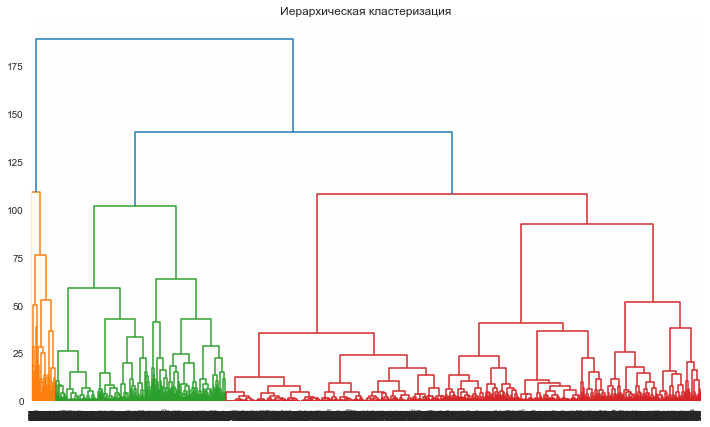

In [99]:
sc = StandardScaler()
x_sc = sc.fit_transform(users.set_index('user_id')) 
 
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

В общей сложности можно выделить три кластера. Создадим модель `k_means` с 3-мя кластерами и запишем метки для каждого пользователя в датафрейме `users`.

In [100]:
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(x_sc)
users['cluster'] = labels

In [101]:
users['cluster'].value_counts()

0    2255
2    1664
1     374
Name: cluster, dtype: int64

Алгоритм выделил следующие размеры кластеров:
- смежная группа - 2 255 чел.;
- целевая группа 1 - 374 чел.;
- целевая группа 2 - 1 664 чел. 

Самый минимальный сегмент насчитывает 374 чел. (кластер 1), что составляет 16,6% от самого максимального сегмента (2 255 чел., кластер 0). Это больше 10%, а значит основное требование к делению на группы соблюдено и сегментация проведена корректно.

Расмотрим различие признаков полученных кластеров, расчитав их средние значения.

In [102]:
users.groupby(['cluster']).mean()

,time_spent_total,minutes_spent,hours_spent,active_days,total_sessions,avg_intervals,avg_hours_breakup,avg_days_breakup,avg_target_time,min_sess_dur,max_sess_dur,avg_sess_dur,contacts_show_share,total_events,avg_events_per_day,avg_events_per_hour,avg_events_per_session,avg_events_per_week,avg_time_spent_per_day,avg_hours_per_week
cluster,,,,,,,,,,,,,,,,,,,,
0,859.049667,14.317494,0.238625,1.020399,1.015521,103.613317,668.587427,27.857809,2.072681e+06,854.029268,856.842129,855.904336,0.047795,8.588914,8.509248,7.430355,8.532191,8.528748,850.214860,0.237436
1,9216.128342,153.602139,2.560036,3.754011,6.628342,134.026141,173.173672,7.215570,1.377785e+06,1476.770053,4538.291444,3436.493689,0.062189,78.639037,38.155183,19.878655,30.612906,55.996177,4359.876791,1.810104
2,1559.877404,25.997957,0.433299,2.471154,3.364784,102.427471,56.180738,2.340864,1.696640e+06,356.270433,1034.859976,779.045384,0.071937,15.275240,8.778744,6.008965,6.749271,11.857436,933.682092,0.340254


Кластер 0 включает в себя смежную группу пользователей (2 255 чел.):

- имеют не более 1 дня активности;
- совершили не более 1-2 сессий;
- средняя сессия длится около 14 минут;
- в среднем заходили в приложение лишь 1 раз за 28 дней;
- в день активности провели в приложении не более 14 минут;
- имеют в среднем не более 9 событий, среди которых очень редко встречается целевое действие.


Кластер 1 включает в себя самых мотивированных пользователей (374 чел.):

- имеют около 4-х дней активности;
- совершают больше всего сессий - более 6;
- средняя сессия длится около 1 часа;
- в среднем заходят в приложение раз в неделю;
- в день активности проводят в приложении более 1 часа; 
- за день активности совершают 38 действий суммарно и 30 действий за сессию;
- имеют наибольшее количество событий - более 78.

Кластер 2 включает в себя заинтересованных пользователей (1 664 чел.):

- имеют более 2-х дней активности;
- совершили более 3 сессий;
- в среднем заходят каждые 2-3 дня;
- средняя сессия длится около 13 минут;
- в день активности проводят в приложении 15 минут в день;
- в день активности совершают 15 действий суммарно и 7 действий за сессию.


[Назад к содержанию](#table_of_contents)

## Шаг 5. Основные вопросы исследования <a class='anchor' id='step_5'></a>

### Определение группы, склонной чаще возвращаться в приложение <a class='anchor' id='step_5_1'></a>

Посмотрим, как различаются коэффициенты удержания среди кластеров.

In [103]:
cluster_0 = users[users['cluster'] == 0][['user_id', 'cluster']].merge(data, on='user_id', how='inner')
cluster_1 = users[users['cluster'] == 1][['user_id', 'cluster']].merge(data, on='user_id', how='inner')
cluster_2 = users[users['cluster'] == 2][['user_id', 'cluster']].merge(data, on='user_id', how='inner')

In [104]:
retention_cluster_0 = retention_rate(cluster_0)
retention_cluster_1 = retention_rate(cluster_1)
retention_cluster_2 = retention_rate(cluster_2)

Построим тепловую карту коэффициентов удержания для смежной группы (кластер 0).

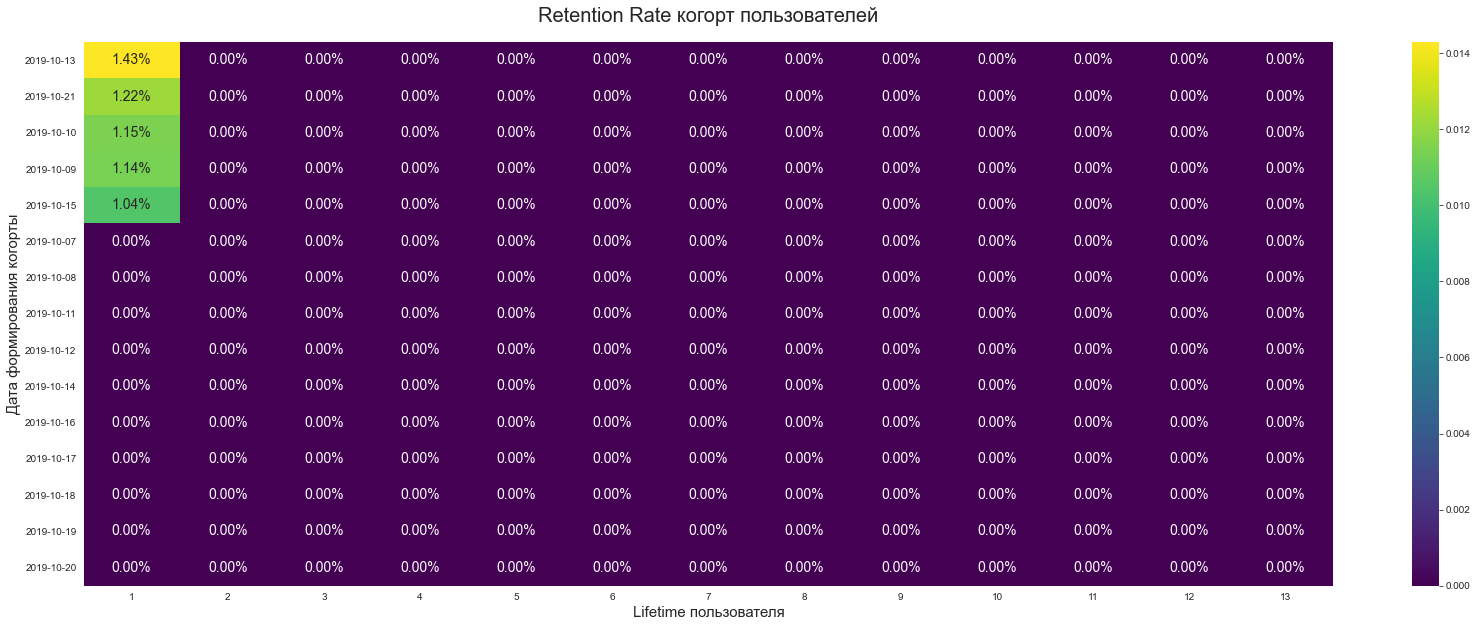

In [105]:
show_retention(retention_cluster_0)

Как мы видим, пользователи данного кластера уже больше не возвращались в приложение.

Посмотрим на удержание мотивированной части целевой группы (кластер 1).

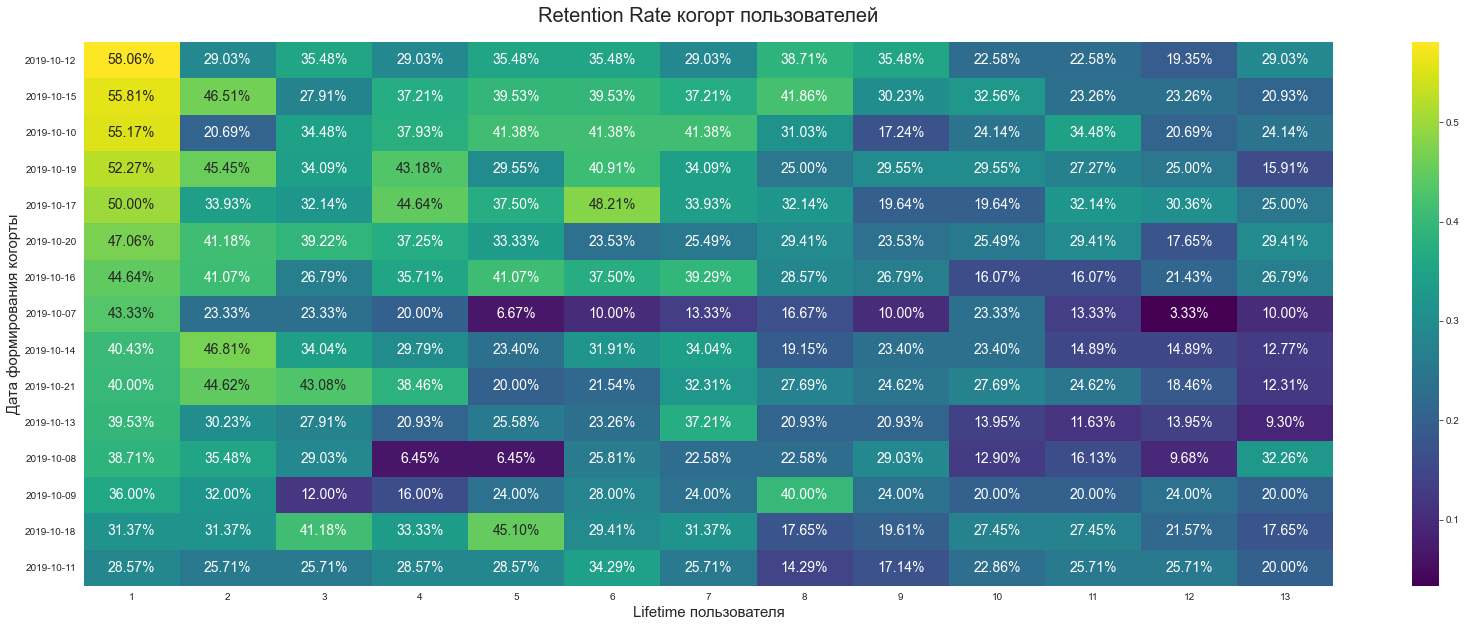

In [106]:
show_retention(retention_cluster_1)

Кластер 1 демонстрирует наиболее высокое и долгое удержание по сравнению со всеми другими пользователями.

Посмотрим на удержание заинтересованной части целевой группы (кластер 2).

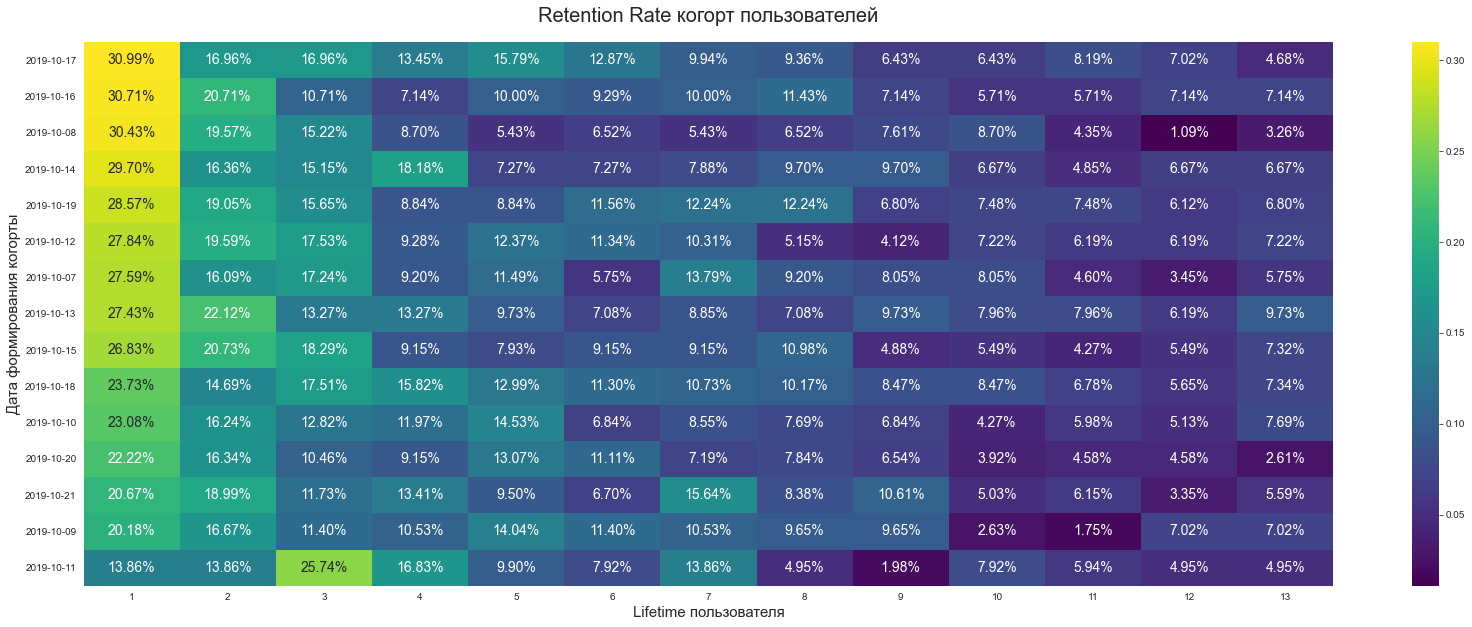

In [107]:
show_retention(retention_cluster_2)

Кластер 2 демонстрирует в целом умеренное удержание на среднем уровне датасета.

### Определение группы, склонной чаще совершать целевое действие <a class='anchor' id='step_5_2'></a>

Расмотрим конверсию в разрезе кластеров.

In [108]:
conversion_cluster_0 = conversion_rate(cluster_0)
conversion_cluster_1 = conversion_rate(cluster_1)
conversion_cluster_2 = conversion_rate(cluster_2)

Построим тепловую карту смежной группы (кластер 0).

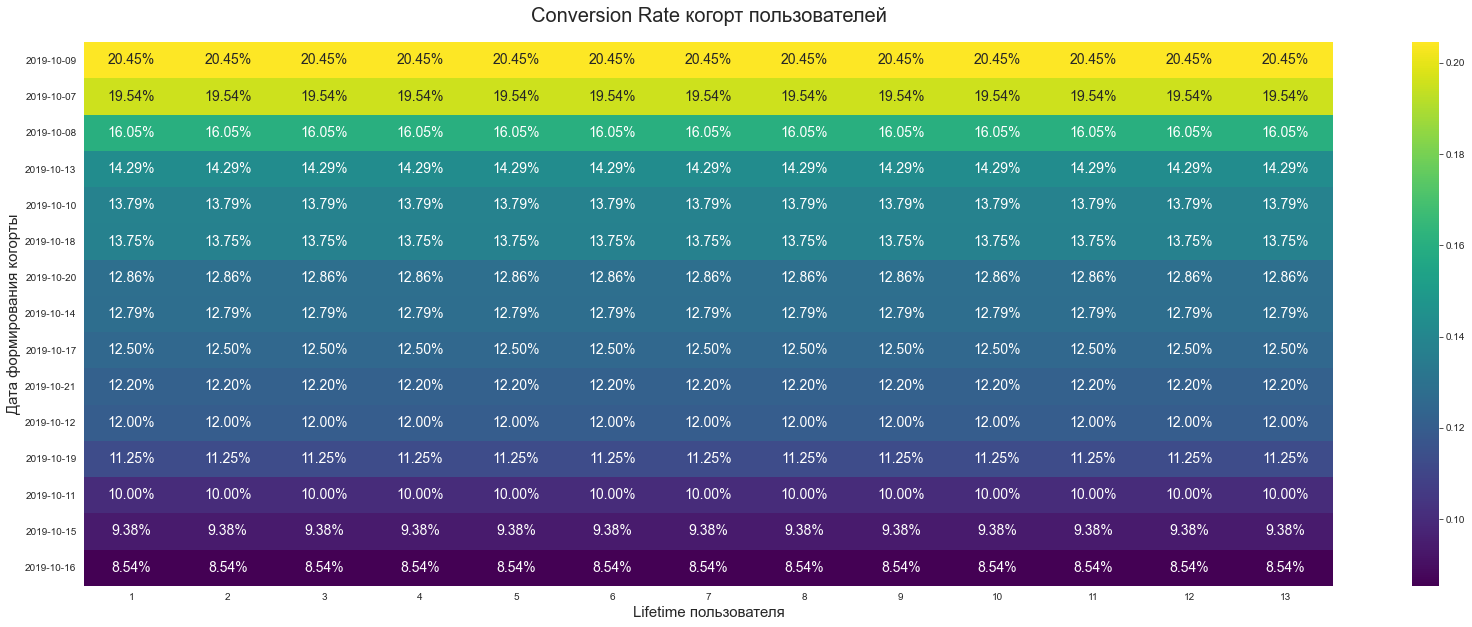

In [109]:
show_conversion(conversion_cluster_0)

Как видим, конверсия когорт совершенно не менялась с течением лайфтайма. Совершив целевое действие, пользователи уже больше не вернулись в приложение.

Посмотрим на конверсию мотивированной части целевой группы (кластер 1).

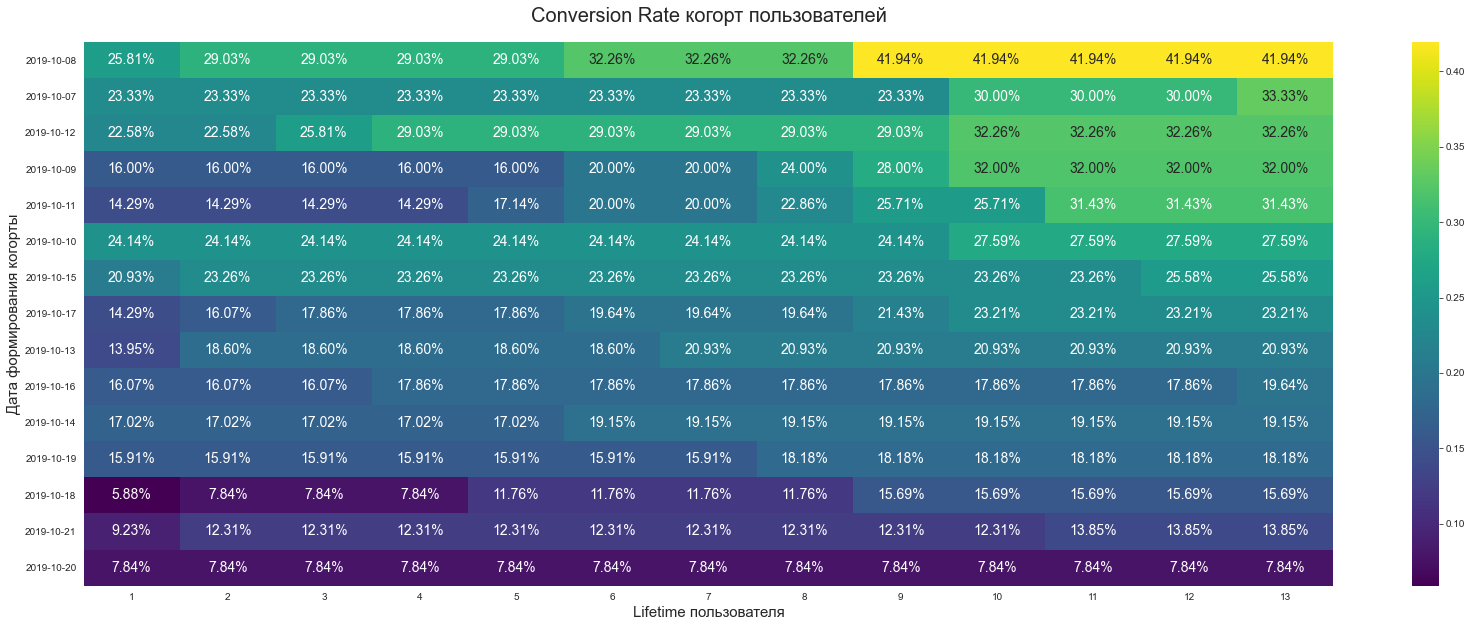

In [110]:
show_conversion(conversion_cluster_1)

Кластер 1 демонстрирует самые высокие значения конверсии среди всех пользователей - до 42% на 13-й день лайфтайма (когорта от 8 октября). Наиболее слабый результат показала когорта от 20 октября: пользователи продолжали удерживаться в приложении, но перестали совершать целевое действие.

Посмотрим на конверсию заинтересованной части целевой группы (кластер 2).

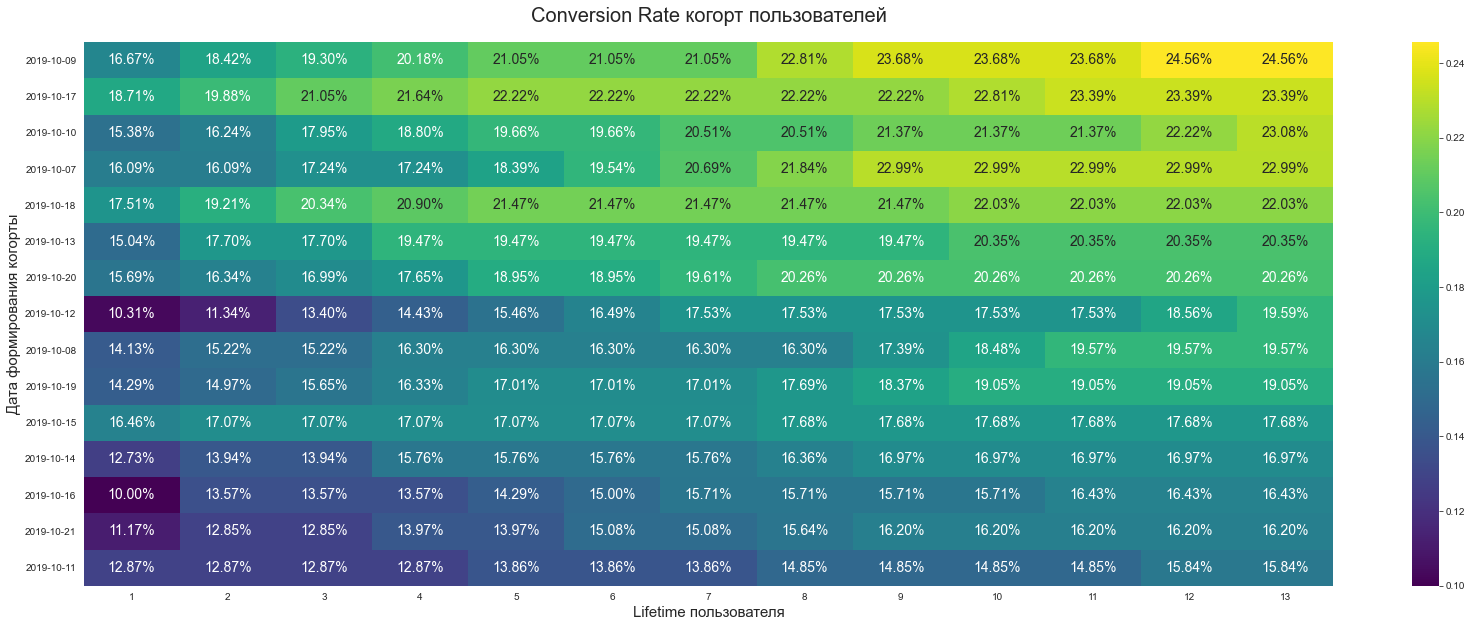

In [111]:
show_conversion(conversion_cluster_2)

Среди всех когорт кластера 2 наблюдается постепенный рост конверсии - до 24,6% на 13-й день лайфтайма (когорта от 9 октября). Остальные когорты также показывают умеренный прирост.

К группам, склонным чаще возвращаться в приложение и чаще совершать целевое действие относятся:
- мотивированная группа - целевая группа, кластер 1 (374 чел.);
- заинтересованная группа - целевая группа, кластер 2 (1 664 чел.)

Группа, которая прекратила возвращаться в приложение и прекратила совершать целевые действия:
- смежная группа - кластер 0 (2 255 чел.)

### Выводы по шагу 5 <a class='anchor' id='step_5_3'></a>

С помощью иерархической кластеризации было выделено 3 кластера.

**Кластер 0** включает в себя **смежную** группу пользователей (2 255 чел.):
- имеют не более 1 дня активности;
- совершили не более 1-2 сессий;
- средняя сессия длится около 14 минут;
- в среднем заходили в приложение лишь 1 раз за 28 дней;
- в день активности провели в приложении не более 14 минут;
- имеют в среднем не более 9 событий, среди которых очень редко встречается целевое действие.

Пользователи **кластера 0** уже больше не возвращались в приложение. Конверсия когорт совершенно не менялась с течением лайфтайма. Совершив целевое действие, пользователи уже больше не вернулись в приложение.

**Кластер 1** включает в себя самых **мотивированных** пользователей (374 чел.):
- имеют около 4-х дней активности;
- совершают больше всего сессий - более 6;
- средняя сессия длится около 1 часа;
- в среднем заходят в приложение раз в неделю;
- в день активности проводят в приложении более 1 часа; 
- за день активности совершают 38 действий суммарно и 30 действий за сессию;
- имеют наибольшее количество событий - более 78.

**Кластер 1** демонстрирует наиболее высокое и долгое удержание по сравнению со всеми другими пользователями. Также кластер 1 демонстрирует самые высокие значения конверсии среди всех пользователей - до 42% на 13-й день лайфтайма (когорта от 8 октября). Наиболее слабый результат показала когорта от 20 октября: пользователи продолжали удерживаться в приложении, но перестали совершать целевое действие.

**Кластер 2** включает в себя заинтересованных пользователей (1 664 чел.):
- имеют более 2-х дней активности;
- совершили более 3 сессий;
- в среднем заходят каждые 2-3 дня;
- средняя сессия длится около 13 минут;
- в день активности проводят в приложении 15 минут в день;
- в день активности совершают 15 действий суммарно и 7 действий за сессию.

**Кластер 2** демонстрирует в целом умеренное удержание на среднем уровне датасета. Среди всех когорт кластера 2 наблюдается постепенный рост конверсии - до 24,6% на 13-й день лайфтайма (когорта от 9 октября). Остальные когорты также показывают умеренный прирост.

К группам, склонным чаще возвращаться в приложение и чаще совершать целевое действие относятся:

- мотивированная группа - целевая группа, **кластер 1** (374 чел.);
- заинтересованная группа - целевая группа, **кластер 2** (1 664 чел.)

Группа, которая прекратила возвращаться в приложение и прекратила совершать целевые действия:

- смежная группа - **кластер 0** (2 255 чел.)

[Назад к содержанию](#table_of_contents)

## Шаг 6. Проверка гипотез <a class='anchor' id='step_6'></a>

Объявим функцию `z_test`, которая в качестве аргументов будет принимать размер групп. За уровень значимости по умолчанию будет отвечать аргумент `alpha=0.05`. 

In [112]:
def z_test(group_1, group_2, target_action_1, target_action_2, alpha=0.05):
    
    successes = np.array([
        target_action_1,
        target_action_2   
    ])

    trials = np.array([
        group_1,
        group_2
    ])

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'Доля целевых действий группы 1 ({group_1} чел.): {"{:.2%}".format(p1)}')
    print(f'Доля целевых действий группы 2 ({group_2} чел.): {"{:.2%}".format(p2)}')
    print('Разница:', "{:.2%}".format(difference))
    print('Уровень значимости:', alpha)
    print('p-value: ', '{:.4}'.format(p_value))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

### Гипотеза 1 <a class='anchor' id='step_6_1'></a>

Поскольку будет проводиться проверка 2-х гипотез, во избежание увеличения вероятности совершить ошибку I рода (ложнопозитивный результат) необходимо скорректировать уровень значимости. Воспользуемся поправкой Бонферрони - разделим уровень значимости на количество проводимых попарных сравнений (2 проверки).

In [113]:
alpha = 0.05
bonferroni_alpha = alpha / 2
bonferroni_alpha

0.025

Некоторые пользователи установили приложение по ссылке из Yandex, другие — из Google. Проверим гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

Первая группа - установила приложении по ссылке из `yandex`.

Вторая группа - установила приложении по ссылке из `google`.

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Группы демонстрируют одинаковую конверсию в целевое действие.}\\
   H_1 :\text{Группы демонстрируют различную конверсию в целевое действие.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Расчитаем необходимые размеры выборок:
- `yandex_users` - число пользователей из Yandex;
- `google_users` - число пользователей из Google;
- `yandex_users_target` - число пользователей из Yandex, совершивших целевое действие;
- `google_users_target` - число пользователей из Google, совершивших целевое действие.

In [114]:
yandex_users = len(data[data['source'] == 'yandex']
                   .groupby('user_id', as_index=False)
                   .agg({'event_name':'count'})
                   .drop_duplicates())
yandex_users_target = len(data[(data['source'] == 'yandex') & (data['event_name'] == 'contacts_show')]
                          .groupby('user_id', as_index=False)
                          .agg({'event_name':'count'})
                          .drop_duplicates())
google_users = len(data[data['source'] == 'google']
                   .groupby('user_id', as_index=False)
                   .agg({'event_name':'count'})
                   .drop_duplicates())
google_users_target = len(data[(data['source'] == 'google') & (data['event_name'] == 'contacts_show')]
                          .groupby('user_id', as_index=False)
                          .agg({'event_name':'count'})
                          .drop_duplicates())

In [115]:
print('Всего пользователей из Yandex:', yandex_users)
print('Всего пользователей из Google:', google_users)
print('Всего пользователей из Yandex, совершивших целевое действие:', yandex_users_target)
print('Всего пользователей из Google, совершивших целевое действие:', google_users_target)

Всего пользователей из Yandex: 1934
Всего пользователей из Google: 1129
Всего пользователей из Yandex, совершивших целевое действие: 478
Всего пользователей из Google, совершивших целевое действие: 275


Проведем z-test.

In [116]:
z_test(yandex_users,
       google_users,
       yandex_users_target,
       google_users_target,
       bonferroni_alpha)

Доля целевых действий группы 1 (1934 чел.): 24.72%
Доля целевых действий группы 2 (1129 чел.): 24.36%
Разница: 0.36%
Уровень значимости: 0.025
p-value:  0.8244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как видим из теста, разница между группами составляет 0.36%, но группы не имеют между собой статистически значимых различий. При верности нулевой гипотезы с вероятностью 82% различия между ними получены случайно. Группы демонстрируют одинаковую конверсию в целевое действие.

### Гипотеза 2 <a class='anchor' id='step_6_2'></a>

Конверсия в целевое действие пользователей, которые совершают долгие сессии, отличается от конверсии пользователей, которые совершают короткие сессии.

Первая группа - совершает долгие сессии (их средняя продолжительность в секундах выше, чем у 75% пользователей)

Вторая группа - совершает быстрые сессии (их средняя продолжительность в секундах ниже, чем у 75% пользователей)

<p>Введем основную и альтернативные гипотезы:</p>

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Группы демонстрируют одинаковую конверсию в целевое действие.}\\
   H_1 :\text{Группы демонстрируют различную конверсию в целевое действие.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Данные о средних длительностях сессий хранятся в столбце `avg_sess_dur` сводного датафрейма `users`. Рассмотрим значения 25%-го и 75%-го персентилей.

In [117]:
print('Короткая сессия продолжается менее', np.percentile(users['avg_sess_dur'], 25).round(2), 'секунд')
print('Долгая сессия продолжается более', np.percentile(users['avg_sess_dur'], 75).round(2), 'секунд')

Короткая сессия продолжается менее 295.78 секунд
Долгая сессия продолжается более 1404.78 секунд


Расчитаем необходимые размеры выборок.

In [118]:
long_sessions = users[users['avg_sess_dur'] > np.percentile(users['avg_sess_dur'], 75)]

long_session_users = (long_sessions[['user_id', 'avg_sess_dur']]
                      .merge(data, on='user_id', how='inner')
                      .groupby('user_id', as_index=False)
                      .agg({'event_name':'count'})
                      .rename(columns={'event_name':'total'}))

long_session_users_target = len(data
                                .merge(long_session_users, on='user_id', how='inner')
                                .query('event_name == "contacts_show"')
                                .groupby('user_id', as_index=False)
                                .agg({'event_name':'count'}))

In [119]:
short_sessions = users[users['avg_sess_dur'] < np.percentile(users['avg_sess_dur'], 25)]

short_session_users = (short_sessions[['user_id', 'avg_sess_dur']]
                       .merge(data, on='user_id', how='inner')
                       .groupby('user_id', as_index=False)
                       .agg({'event_name':'count'})
                       .rename(columns={'event_name':'total'}))


short_session_users_target = len(data
                                 .merge(short_session_users, on='user_id', how='inner')
                                 .query('event_name == "contacts_show"')
                                 .groupby('user_id', as_index=False)
                                 .agg({'event_name':'count'}))

In [120]:
print('Всего пользователей с долгими сессиями:', len(long_session_users))
print('Всего пользователей с короткими сессиями:', len(short_session_users))
print('Всего пользователей с долгими сессиями, совершивших целевое действие:', long_session_users_target)
print('Всего пользователей с короткими сессиями, совершивших целевое действие:', short_session_users_target)

Всего пользователей с долгими сессиями: 1073
Всего пользователей с короткими сессиями: 1073
Всего пользователей с долгими сессиями, совершивших целевое действие: 316
Всего пользователей с короткими сессиями, совершивших целевое действие: 211


In [121]:
z_test(len(long_session_users),
       len(short_session_users),
       long_session_users_target,
       short_session_users_target,
       bonferroni_alpha)

Доля целевых действий группы 1 (1073 чел.): 29.45%
Доля целевых действий группы 2 (1073 чел.): 19.66%
Разница: 9.79%
Уровень значимости: 0.025
p-value:  1.395e-07
Отвергаем нулевую гипотезу: между долями есть значимая разница



Как видим из теста, разница между группами составляет 9.79% и группы имеют между собой статистически значимые различия, о чем свидетельствует очень низкий p-value (0.0000001395). Отвергаем нулевую гипотезу - группы демонстрируют различную конверсию в целевое действие.

Конверсия в целевое действие пользователей, которые совершают долгие сессии, отличается от конверсии пользователей, которые совершают короткие сессии.

[Назад к содержанию](#table_of_contents)

## Выводы и рекомендации <a class='anchor' id='final'></a>

### Выводы <a class='anchor' id='final_1'></a>

По итогам анализа Retention Rate были получены следующие выводы:

1. Наилучшее удержание показывают когорты, начавшие активность 12, 16, 17 и 19 октября (всего 4 когорты). 

2. В среднем их удержание составляло 24-26% на 1-й день лайфтайма, 11-13% на 7-й день лайфтайма, 6-9% на 13-й день лайфтайма.

3. Худшее удержание показывают когорты, начавшие активность с 7 по 11 октября (всего 5 когорт).

4. В среднем их удержание составляло 11-20% на 1-й день лайфтайма, 6-11% на 7-й день лайфтайма, 4-7% на 13-й день лайфтайма.

По итогам анализа времени, проведенного в приложении, были получены следующие выводы:

1. Подавляющее число пользователей (более 86%) провело в приложении не более 1 часа за 28 дней. 2% пользователей не пользовались приложением в исследуемом периоде.

2. 64% пользователей (2 756 чел.) имели лишь один день активности за 28 дней; 18% пользователей (786 чел.) имели два дня активности; 8% пользователей (346 чел.) имели три дня активности; 10% пользователей (405 чел.) были активны 4 дня и более.

3. 53% пользователей (2 300 чел.) имели лишь одну сессию за 28 дней; 20% пользователей (878 чел.) имели две сессии; 10% пользователей (462 чел.) имели три сессии; 17% пользователей (653 чел.) провели 4 сессии и более.

По итогам анализа частоты действий были получены следующие выводы:

1. На протяжении всего времени в среднем пользовательская активность держится на уровне 2 000 - 3 000 событий в день. Самым активным днем было 23 октября - в этот день произошло 3 361 событий, из которых 239 целевых действий.

2. Наименее активным днем было 12 октября - в этот день произошло лишь 1 843 события.

3. В среднем уровень целевых действий держится на уровне 50-270 в день, достигая не более 10% от всех действий за день.

4. Больше всего целевых действий было совершено 17 октября - 265 событий (10% от событий этого дня). Наименьшее количество было совершено 12 октября - лишь 54 (3% от всех событий).

5. Пользовательская активность падает в ночные часы, и, начиная с 6 утра постепенно начинает возрастать. Пиковые значения активности приходятся на 15 часов дня, достигая уровня более 5 600 событий. Далее происходит спад, после которого в период с 18 до 21 часа наблюдается новый рост до уровня максимумов за день.

6. Похожим образом распределяются и целевые действия. Их пиковые значения приходятся в отрезок с 11 часов утра до 16 часов дня - в среднем на уровне 400 действий в час (около 7-9% от всех событий).

7. Наибольшая активность пользователей приходится на понедельник, после чего постепенно снижается в течение всей недели. Количество целевых действий напротив возрастает, начиная с понедельника и достигает максимума в четверг. Наиболее низкие значения целевых действий пользователи демонстрируют в выходные дни.

8. В среднем пользователи имеют 17 событий за исследуемый период. Медианное значение - 9 событий. Количество событий 90% пользователей составляет не более 36 событий. Лишь 5% пользователей совершили более 59 действий.

9. В среднем интервал пользователя между событиями внутри сессии составляет 1 минута 45 секунд (105 секунд). Медианное значение интервалов составляет около полторы минуты (85 секунд). Размер интервалов между действиями 75% пользователей не превышает 2-х минут (138 секунд). 10% пользователей имеют интервалы более 3.5 минут (213 секунд) и лишь 1% - более 7 минут (416 секунд).

10. В расчетах учтены только те пользователи, которые совершили как минимум 2 сессии. В среднем перерыв между сессиями пользователей составляет 2 с половиной дня. Медианное значение - 1 день. 

11. Из всех активных пользователей (всего 1 993 чел.): 50% пользователей заходят в приложение 1 раз в 2 дня; 75% пользователей заходят в приложение каждые 3 дня; 9% пользователей заходят 1 раз в неделю; 4% заходят раз в 10 дней;
лишь 2% заходят раз в 2 недели.

12. Средний размер сессии - 18 минут (1 071 секунд). Медианное значние - 12 минут (708 секунд). Максимум составил более 5 часов. Длительность сессии 89% пользователей не превышает 40 минут (2 500 секунд). Длительность сессии 10% пользователей варьируется в интервале от 40 минут до 1 часа 20 минут. Лишь 1% пользователей совершает сессии дольше, чем полтора часа.

По итогам анализа конверсии были получены следующие выводы:

1. В плане конверсии пользователи разбились на две части. Наилучшую конверсию показывают когорты от 7-10, 12, 13, 17 и 18 октября (всего 8 когорт).

2. В среднем их конверсия составляла: 19-24% на 13-й день лайфтайма; 18-21% на 7-й день лайфтайма; 13-19% на 1-й день лайфтайма.

3. Наименьшую конверсию демонстрируют когорты от 11, 14-16, 19-21 октября (всего 7 когорт).

4. В среднем их конверсия составляла: 15-17% на 13-й день лайфтайма; 14-16% на 7-й день лайфтайма; 11-15% на 1-й день лайфтайма.

5. Среди пользователей, которые совершали целевое действие, в среднем 23% действий составляет просмотр контактов.

С помощью иерархической кластеризации было выделено 3 кластера.

Кластер 0 включает в себя смежную группу пользователей (2 255 чел.):
- имеют не более 1 дня активности;
- совершили не более 1-2 сессий;
- средняя сессия длится около 14 минут;
- в среднем заходили в приложение лишь 1 раз за 28 дней;
- в день активности провели в приложении не более 14 минут;
- имеют в среднем не более 9 событий, среди которых очень редко встречается целевое действие.

Пользователи данного кластера уже больше не возвращались в приложение. Конверсия когорт совершенно не менялась с течением лайфтайма. Совершив целевое действие, пользователи уже больше не вернулись в приложение.

Кластер 1 включает в себя самых мотивированных пользователей (374 чел.):
- имеют около 4-х дней активности;
- совершают больше всего сессий - более 6;
- средняя сессия длится около 1 часа;
- в среднем заходят в приложение раз в неделю;
- в день активности проводят в приложении более 1 часа; 
- за день активности совершают 38 действий суммарно и 30 действий за сессию;
- имеют наибольшее количество событий - более 78.

Кластер 1 демонстрирует наиболее высокое и долгое удержание по сравнению со всеми другими пользователями. Также кластер 1 демонстрирует самые высокие значения конверсии среди всех пользователей - до 42% на 13-й день лайфтайма (когорта от 8 октября). Наиболее слабый результат показала когорта от 20 октября: пользователи продолжали удерживаться в приложении, но перестали совершать целевое действие.

Кластер 2 включает в себя заинтересованных пользователей (1 664 чел.):
- имеют более 2-х дней активности;
- совершили более 3 сессий;
- в среднем заходят каждые 2-3 дня;
- средняя сессия длится около 13 минут;
- в день активности проводят в приложении 15 минут в день;
- в день активности совершают 15 действий суммарно и 7 действий за сессию.

Кластер 2 демонстрирует в целом умеренное удержание на среднем уровне датасета. Среди всех когорт кластера 2 наблюдается постепенный рост конверсии - до 24,6% на 13-й день лайфтайма (когорта от 9 октября). Остальные когорты также показывают умеренный прирост.

К группам, склонным чаще возвращаться в приложение и чаще совершать целевое действие относятся:

- мотивированная группа - целевая группа, кластер 1 (374 чел.);
- заинтересованная группа - целевая группа, кластер 2 (1 664 чел.)

Группа, которая прекратила возвращаться в приложение и прекратила совершать целевые действия:

- смежная группа - кластер 0 (2 255 чел.)

По итогам проверки 1-й гипотезы о различии конверсии между группами из Yandex и Google, разница между группами составляет 0.36%, но группы не имеют между собой статистически значимых различий. При верности нулевой гипотезы с вероятностью 82% различия между ними получены случайно. Группы демонстрируют одинаковую конверсию в целевое действие.

По итогам проверки 2-й гипотезы о различии конверсии между группами с короткими и длинными сессиями, разница между группами составляет 9.79% и группы имеют между собой статистически значимые различия, о чем свидетельствует очень низкий p-value (0.0000001395). Нулевая гипотеза отвержена - группы демонстрируют различную конверсию в целевое действие.
Конверсия в целевое действие пользователей, которые совершают долгие сессии, отличается от конверсии пользователей, которые совершают короткие сессии.

### Рекомендации по развитию приложения <a class='anchor' id='final_2'></a>

1. Разработать для пользователей форму обратную связь и оценки User Experience, чтобы узнать, почему они больше не вернулись в приложение.
2. Если пользователь не заходил в приложение более 2-3-х дней - с помощью push-уведомлений уведомлять его о новых товарах и объявлениях на основе личной истории поиска и просмотров.
3. С помощью push-уведомлений уведомлять мотивированных и заинтересованных пользователей об обновлении, новых товарах, акциях, скидках, специальных предложениях и другом.
4. Тщательно проанализировать последние действия пользователя в приложении перед уходом на длительный срок - возможно, он не нашел, что искал.
5. Собирать информацию о количестве удалений нашего приложения со смартфонов. Выяснить, почему пользователи удаляют ваше приложение и подключить дополнительные каналы коммуникации для возврата пользователей.
6. Создать для пользователей чат-бота, который помогал в поиске информации и подсказывал о всех возможностях приложения. Это может помочь продлить пользовательскую сессию и удержать пользователя в приложении.
7. Добавить данные о логировании пользователей для более точного определения длительности сессии.

[Назад к содержанию](#table_of_contents)